<a href="https://colab.research.google.com/github/Vridhi-Wadhawan/bank-marketing-mlops/blob/main/ML_Ops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning Operations (MLOps)

### By

### Vridhi Wadhawan

## Business Understanding

* **Business Problem :**
    Improve efficiency of term deposit marketing campaigns by targeting customers with higher likelihood to subscribe.

* **Objective :**
    Deploy a model to maximize the F1 Score such that ensuring a strong balance between precision and recall — while minimizing the number of unnecessary customer contacts

* **Constraints :**
    * Limited marketing budget restricts the number of contacts
    * High false positives (contacting uninterested customers) must be minimized to preserve resources and customer goodwill.

* **Success Metrics :**
    * *Business:* Atleast 10% reduction in ineffective outreach
    * *ML:* Improve an F1 Score ≥ 0.40
    * *Economic:* Projected annual ROI >15% through smarter targetting

## Import Libraries

In [ ]:
# Importing Libraries

!pip install feature_engine
!pip install dtale
!pip install -U dtale

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import feature_engine
from scipy import stats
from scipy.stats import shapiro, chi2_contingency
import warnings
import dtale
import pickle
import time
import joblib
import dtale.app as dtale_app
# Set the USE_COLAB flag to True
dtale_app.USE_COLAB = True

# Modeling imports for later
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("viridis")

/usr/local/lib/python3.11/dist-packages/kaleido/__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




## Data Loading And Initial Exploration


#### Loading And Initial Exploration

In [ ]:
# Data Loading And Initial Exploration
def load_and_explore_data(file_path):
    """Load dataset and perform initial exploration"""
    print("*"*50)
    print("LOADING AND EXPLORING DATA")
    print("*"*50)

    # Load data
    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path)

    # Basic info
    print("Basic Info")
    print(f"Dataset shape: {df.shape}")
    print(f"\nFirst 5 rows:")
    print(df.head())

    print(f"\nDataset info:")
    print(df.info())

    # Check target distribution
    if 'y' in df.columns:
        print(f"\nTarget variable distribution:")
        print(df['y'].value_counts())

    return df

In [ ]:
df = load_and_explore_data('/content/bank-additional.csv')

**************************************************
LOADING AND EXPLORING DATA
**************************************************
Loading data from: /content/bank-additional.csv
Basic Info
Dataset shape: (4119, 21)

First 5 rows:
   age          job  marital          education default  housing     loan  \
0   30  blue-collar  married           basic.9y      no      yes       no   
1   39     services   single        high.school      no       no       no   
2   25     services  married        high.school      no      yes       no   
3   38     services  married           basic.9y      no  unknown  unknown   
4   47       admin.  married  university.degree      no      yes       no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0   cellular   may         fri  ...         2    999         0  nonexistent   
1  telephone   may         fri  ...         4    999         0  nonexistent   
2  telephone   jun         wed  ...         1    999         0  nonexis

### Business & Statistical Insights

**Dataset Overview**
- Total records: 4,119 customers
- Total features: 21 columns (mix of numerical and categorical)
- Each row represents one customer who was contacted for a term deposit campaign

**Business Insights**
- Target variable ('y') is highly imbalanced:
  - 3,668 customers (≈89%) did not subscribe
  - 451 customers (≈11%) subscribed
- The Imblance implies that most of the outreach efforts are not converting
- Predictive modeling can help:
  - Identify likely responders
  - Reduce marketing costs
  - Improve conversion rates

**Statistical Insights**
- No missing values in the dataset
- Feature types:
  - Numerical: age, duration, euribor3m, etc.
  - Categorical: job, marital status, contact type, etc.
- Economic indicators included:
  - emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed
  - Economic conditions may influence customer decisions

## Data Cleaning And Pre-Processing

#### Data Cleaning

In [ ]:
# Data Cleaning
def clean_data(df):
    """Performing comprehensive data cleaning"""
    print("\n" + "*"*50)
    print("DATA CLEANING")
    print("*"*50)

    # Check for duplicates
    print(f"Checking for duplicate rows...")
    duplicate_count = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_count}")
    if duplicate_count > 0:
        df = df.drop_duplicates()
        print(f"Removed {duplicate_count} duplicate rows")

    # Check for missing values
    print(f"\nChecking for missing values...")
    missing_summary = df.isnull().sum()
    print(f"\nMissing values per column:\n{missing_summary[missing_summary > 0]}")

    # Check for 'unknown' values
    print(f"\nChecking for 'unknown' values...")
    unknown_counts = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            unknown_count = (df[col] == 'unknown').sum()
            if unknown_count > 0:
                unknown_counts[col] = unknown_count

    if unknown_counts:
        print(f"\n'Unknown' values found:")
        for col, count in unknown_counts.items():
            pct = count / len(df) * 100
            print(f"{col}: {count} ({pct:.2f}%)")

    return df

In [ ]:
df = clean_data(df)


**************************************************
DATA CLEANING
**************************************************
Checking for duplicate rows...
Number of duplicate rows: 0

Checking for missing values...

Missing values per column:
Series([], dtype: int64)

Checking for 'unknown' values...

'Unknown' values found:
job: 39 (0.95%)
marital: 11 (0.27%)
education: 167 (4.05%)
default: 803 (19.50%)
housing: 105 (2.55%)
loan: 105 (2.55%)


#### Business And Statistical Insights

**Dataset Overview**

Duplicate And Missing Values
- No duplicate rows found — data quality is intact.
- No missing values in any column — no need for imputation.

'Unknown' Values (Treated as Missing)
- Some columns contain 'unknown' as a placeholder:
  - default: 803 entries (19.5%)
  - education: 167 entries (4.05%)
  - housing & loan: 105 each (2.55%)
  - job: 39 entries (0.95%)
  - marital: 11 entries (0.27%)

**Business Insights**
- High number of 'unknown' values in default column might indicate that the customers are reluctant to disclose financial risk — which could be a red flag for targeting
- Education and job-related unknowns suggest incomplete profiling, which may inturn affect how well the bank understands its customer base

**Statistical Insights**
- Even though there are no nulls, 'unknown' values need to be handled carefully (e.g., treated as a separate category or imputed).
- Clean data ensures more reliable model training and evaluation.

#### Feaature Engneering And Pre-Processing

In [ ]:
# Feaature Engneering And Pre-Processing
def feature_engineering(df):
    """Create new features and transform existing ones"""
    print("\n" + "*"*50)
    print("FEATURE ENGINEERING")
    print("*"*50)

    # Create binary target
    df['y_binary'] = df['y'].map({'yes': 1, 'no': 0})

    # Behavioral features
    df['recently_contacted'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)
    df['contact_intensity'] = df['campaign'] / (df['duration'] + 1)

    # Employment and risk features
    employed_jobs = ['admin.', 'technician', 'management', 'services', 'blue-collar']
    df['is_employed'] = df['job'].isin(employed_jobs).astype(int)
    df['is_risk_group'] = ((df['default'] == 'yes') | (df['loan'] == 'yes')).astype(int)

    # Temporal features
    week_mapping = {
        'mon': 'early', 'tue': 'early', 'wed': 'mid',
        'thu': 'late', 'fri': 'late'
    }
    df['week_segment'] = df['day_of_week'].map(week_mapping)

    def map_season(month):
        if month in ['dec', 'jan', 'feb']:
            return 'winter'
        elif month in ['mar', 'apr', 'may']:
            return 'spring'
        elif month in ['jun', 'jul', 'aug']:
            return 'summer'
        else:
            return 'autumn'

    df['season_category'] = df['month'].apply(map_season)

    # Economic pressure index
    df['economic_pressure_index'] = (
        (df['cons.price.idx'] - df['cons.conf.idx']) /
        (df['emp.var.rate'] + 1 + 1e-6)
    )

    # Age groups
    df['age_group'] = pd.cut(df['age'],
                            bins=[0, 30, 45, 60, 100],
                            labels=['young', 'middle', 'senior', 'elderly'])

    print(f"Created {len([col for col in df.columns if col not in ['y']])} features")

    # Segregate variables
    date_vars = ['month', 'day_of_week','week_segment', 'season_category']
    numeric_vars = ['age', 'duration', 'campaign', 'pdays', 'previous','emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m', 'nr.employed','contact_intensity', 'economic_pressure_index']
    categorical_vars = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'poutcome','recently_contacted', 'is_employed', 'is_risk_group','y','y_binary','age_group']

    print("\n")

    print("Date Variables:", date_vars)
    print("Numeric Variables:", numeric_vars)
    print("Categorical Variables:", categorical_vars)

    print("\n")

    df.info()

    return df

In [ ]:
df = feature_engineering(df)


**************************************************
FEATURE ENGINEERING
**************************************************
Created 29 features


Date Variables: ['month', 'day_of_week', 'week_segment', 'season_category']
Numeric Variables: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'contact_intensity', 'economic_pressure_index']
Categorical Variables: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'recently_contacted', 'is_employed', 'is_risk_group', 'y', 'y_binary', 'age_group']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      4119 non-null   int64   
 1   job                      4119 non-null   object  
 2   marital                  4119 non-null   object  
 3  

#### Business And Statistical Insights

**Dataset Overview**

Feature Summary
- Total features after engineering: 30
- New features created: 9
  - y_binary, recently_contacted, contact_intensity, is_employed, is_risk_group, week_segment, season_category, economic_pressure_index, age_group

Classification of Feature Types
- Date-based: month, day_of_week, week_segment, season_category
- Numeric: age, duration, pdays, euribor3m, etc.
- Categorical: job, marital, education, contact, etc.
- Binary flags: is_employed, recently_contacted, y_binary

**Business Insights**

- New features like is_risk_group and economic_pressure_index help the bank assess customer risk and economic sensitivity which is useful for targeting
- Segmenting by week or season can help reveal when customers are more responsive to campaigns
- Flags like recently_contacted prevent over-contacting the same customer, improving customer experience.

**Statistical Insights**
- Feature diversity (categorical, numeric, temporal) helps to enriche the model’s ability to learn patterns.
- Binary encoding (e.g., y_binary) simplifies classification tasks
- Engineered features add business context and helps to improve model interpretability


## Exploratory Data Analysis

#### Exploratory Data Analysis

In [ ]:
# Segregate variables
date_vars = ['month', 'day_of_week','week_segment', 'season_category']
numeric_vars = ['age', 'duration', 'campaign', 'pdays', 'previous','emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m', 'nr.employed','contact_intensity', 'economic_pressure_index']
categorical_vars = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'poutcome','recently_contacted', 'is_employed', 'is_risk_group','y','y_binary','age_group']

Comprehensive exploratory data analysis with visualizations
Parameters:
* df (DataFrame): Input dataset
* numeric_vars (list): List of numerical variable names
* categorical_vars (list): List of categorical variable names
* date_vars (list): List of date-related variable names

In [ ]:
def perform_eda(df):

    # Validate input
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")

    print("\n" + "*"*50)
    print("EXPLORATORY DATA ANALYSIS")
    print("*"*50)

    sns.light_palette("navy")

    # Target analysis
    print(f"\nTARGET VARIABLE ANALYSIS:")
    target_dist = df['y_binary'].value_counts()
    print(f"Distribution:\n{target_dist}")
    print(f"Positive rate: {df['y_binary'].mean():.3f}")

    print("\n")

    # Numerical Variables Analysis
    print("\nNUMERICAL VARIABLES SUMMARY")
    numeric_summary = df[numeric_vars].describe().T
    numeric_summary['median'] = df[numeric_vars].median()
    numeric_summary['mode'] = df[numeric_vars].mode().iloc[0]
    numeric_summary['variance'] = df[numeric_vars].var()
    numeric_summary['range'] = numeric_summary['max'] - numeric_summary['min']
    numeric_summary['iqr'] = numeric_summary['75%'] - numeric_summary['25%']
    numeric_summary['outliers'] = numeric_summary['iqr'] * 1.5
    numeric_summary['skewness'] = df[numeric_vars].skew()
    numeric_summary['kurtosis'] = df[numeric_vars].kurtosis()
    display(numeric_summary)

    print("\n")

    for col in numeric_vars:
        plt.figure(figsize=(15, 4))
        # Histogram + KDE
        plt.subplot(1, 3, 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.axvline(df[col].mean(), color='red', ls='--')
        plt.title(f'Distribution of {col}')
        # Boxplot
        plt.subplot(1, 3, 2)
        sns.boxplot(x=df[col])
        plt.axvline(df[col].mean(), color='red', ls='--')
        plt.title(f'Boxplot of {col}')
        # Q-Q Plot
        plt.subplot(1, 3, 3)
        stats.probplot(df[col].dropna(), dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {col}')
        plt.tight_layout()
        plt.show()

    # Categorical Variables Analysis
    print("\nCATEGORICAL VARIABLES SUMMARY")
    for col in categorical_vars:
        print(f"\n{col}:\n", df[col].value_counts(dropna=False))

    print("\n")

    plt.figure(figsize=(15, 5*math.ceil(len(categorical_vars)/3)))
    for i, col in enumerate(categorical_vars, 1):
        ax = plt.subplot(math.ceil(len(categorical_vars)/3), 3, i)
        order = df[col].value_counts().index
        sns.countplot(data=df, x=col, order=order, ax=ax)
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=45)
        for bar in ax.patches:
            plt.text(bar.get_x()+bar.get_width()/2, bar.get_height(),
                     int(bar.get_height()), ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

    # Date Variables Analysis
    print("\nDATE VARIABLES ANALYSIS")
    plt.figure(figsize=(15, 10))
    # Month
    plt.subplot(2, 2, 1)
    ax = sns.countplot(data=df, x='month',
                order=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
    for bar in ax.patches:
        plt.text(bar.get_x()+bar.get_width()/2, bar.get_height(),
                 int(bar.get_height()), ha='center', va='bottom')
    plt.title("Contacts by Month")
    # Day of Week
    plt.subplot(2, 2, 2)
    ax = sns.countplot(data=df, x='day_of_week',
                order=['mon','tue','wed','thu','fri'])
    for bar in ax.patches:
        plt.text(bar.get_x()+bar.get_width()/2, bar.get_height(),
                 int(bar.get_height()), ha='center', va='bottom')
    plt.title("Contacts by Day")
    # Week Segment
    plt.subplot(2, 2, 3)
    ax = sns.countplot(data=df, x='week_segment',
                order=['early','mid','late'])
    for bar in ax.patches:
        plt.text(bar.get_x()+bar.get_width()/2, bar.get_height(),
                 int(bar.get_height()), ha='center', va='bottom')
    plt.title("Week Segment")
    # Season
    plt.subplot(2, 2, 4)
    ax = sns.countplot(data=df, x='season_category',
                order=['winter','spring','summer','autumn'])
    for bar in ax.patches:
        plt.text(bar.get_x()+bar.get_width()/2, bar.get_height(),
                 int(bar.get_height()), ha='center', va='bottom')
    plt.title("Season")
    plt.tight_layout()
    plt.show()

    # Bivariate Analysis: Numeric vs Target
    print("\nBIVARIATE ANALYSIS: NUMERIC VS TARGET")
    plt.figure(figsize=(20, 4*math.ceil(len(numeric_vars)/4)))
    for i, col in enumerate(numeric_vars, 1):
        ax = plt.subplot(math.ceil(len(numeric_vars)/4), 4, i)
        sns.boxplot(x='y', y=col, data=df, showmeans=True,
                    meanprops={"markerfacecolor":"red"})
        ax.set_title(f'{col} by Subscription')
    plt.tight_layout()
    plt.show()

    # Bivariate Analysis: Categorical vs Target
    print("\nBIVARIATE ANALYSIS: CATEGORICAL VS TARGET")
    avg = df['y_binary'].mean()
    plt.figure(figsize=(18, 6*math.ceil(len(categorical_vars)/3)))
    for i, col in enumerate(categorical_vars, 1):
        ax = plt.subplot(math.ceil(len(categorical_vars)/3), 3, i)
        order = df.groupby(col)['y_binary'].mean().sort_values().index
        sns.barplot(x=col, y='y_binary', data=df, order=order, ax=ax)
        ax.axhline(avg, color='red', ls='--')
        ax.set_title(f'Subscription Rate by {col}')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

    # Multivariate Analysis
    print("\nMULTIVARIATE ANALYSIS")

    # Correlation Matrix
    corr = df[numeric_vars + ['y_binary']].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()

    # Feature importance by correlation
    target_corr = abs(corr['y_binary'].drop('y_binary')).sort_values(ascending=False)
    print(f"\nTop features by correlation with target:")
    print(target_corr.head(10))

    # Chi-square Tests
    print("\nCHI-SQUARE TEST RESULTS (p-values):")
    for col in categorical_vars:
        ct = pd.crosstab(df[col], df['y_binary'])
        _, p, _, _ = chi2_contingency(ct)
        print(f"{col}: p = {p:.4f}")

    # Dataset Info
    print("\nDATASET INFORMATION:")
    return df.info()


**************************************************
EXPLORATORY DATA ANALYSIS
**************************************************

TARGET VARIABLE ANALYSIS:
Distribution:
y_binary
0    3668
1     451
Name: count, dtype: int64
Positive rate: 0.109



NUMERICAL VARIABLES SUMMARY


,count,mean,std,min,25%,50%,75%,max,median,mode,variance,range,iqr,outliers,skewness,kurtosis
age,4119.0,40.113620,10.313362,18.000000,32.000000,38.000000,47.000000,88.000000,38.000000,32.000000,106.365426,70.000000,15.000000,22.500000,0.715694,0.438130
duration,4119.0,256.788055,254.703736,0.000000,103.000000,181.000000,317.000000,3643.000000,181.000000,77.000000,64873.993194,3643.000000,214.000000,321.000000,3.294781,20.761929
campaign,4119.0,2.537266,2.568159,1.000000,1.000000,2.000000,3.000000,35.000000,2.000000,1.000000,6.595442,34.000000,2.000000,3.000000,4.003185,25.284520
pdays,4119.0,960.422190,191.922786,0.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,36834.355710,999.000000,0.000000,0.000000,-4.775139,20.812484
previous,4119.0,0.190337,0.541788,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.293535,6.000000,0.000000,0.000000,4.022979,22.120323
emp.var.rate,4119.0,0.084972,1.563114,-3.400000,-1.800000,1.100000,1.400000,1.400000,1.100000,1.400000,2.443327,4.800000,3.200000,4.800000,-0.727688,-1.041784
cons.price.idx,4119.0,93.579704,0.579349,92.201000,93.075000,93.749000,93.994000,94.767000,93.749000,93.994000,0.335645,2.566000,0.919000,1.378500,-0.216641,-0.823358
cons.conf.idx,4119.0,-40.499102,4.594578,-50.800000,-42.700000,-41.800000,-36.400000,-26.900000,-41.800000,-36.400000,21.110142,23.900000,6.300000,9.450000,0.287309,-0.314303
euribor3m,4119.0,3.621356,1.733591,0.635000,1.334000,4.857000,4.961000,5.045000,4.857000,4.857000,3.005339,4.410000,3.627000,5.440500,-0.715080,-1.396366
nr.employed,4119.0,5166.481695,73.667904,4963.600000,5099.100000,5191.000000,5228.100000,5228.100000,5191.000000,5228.100000,5426.960015,264.500000,129.000000,193.500000,-1.075877,0.061724


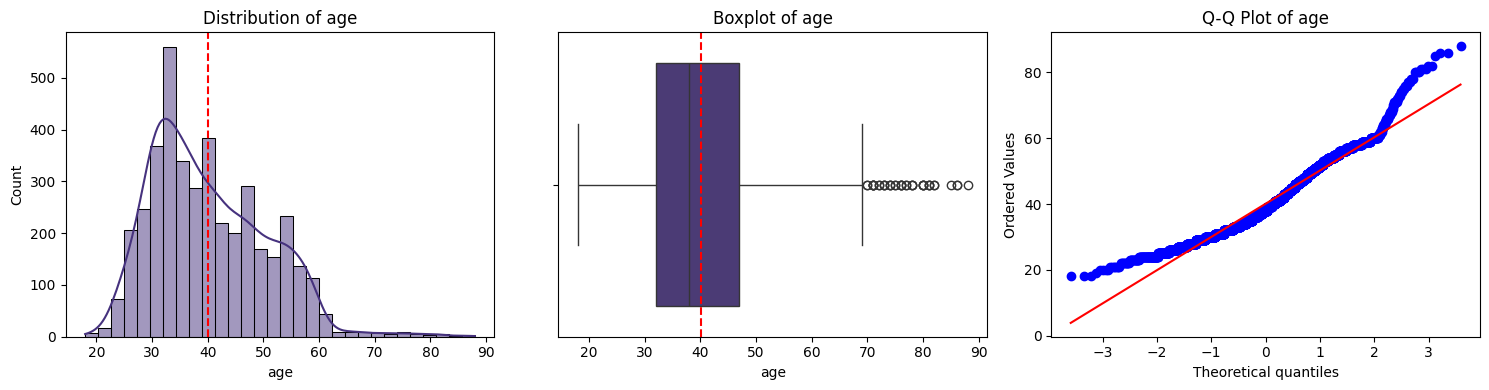

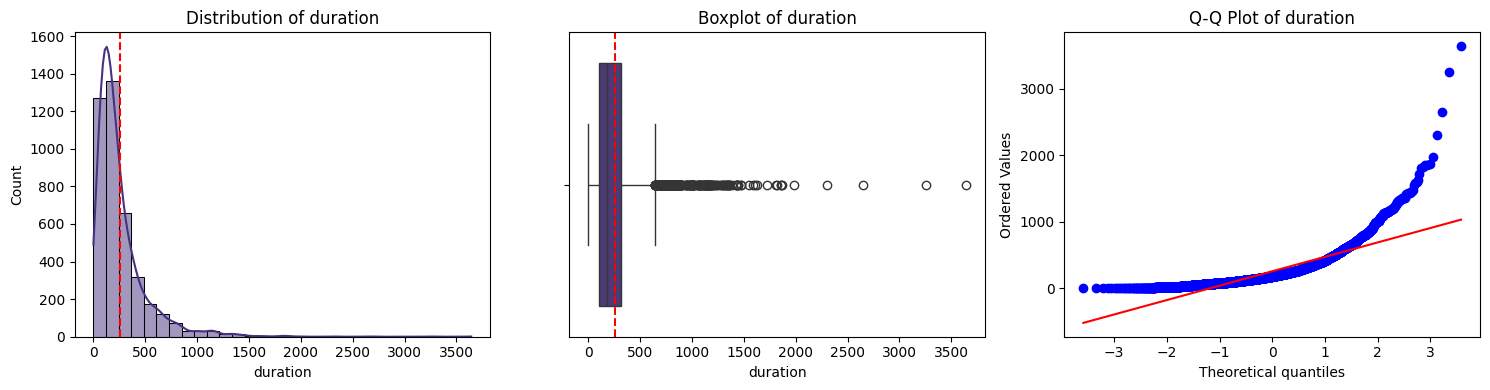

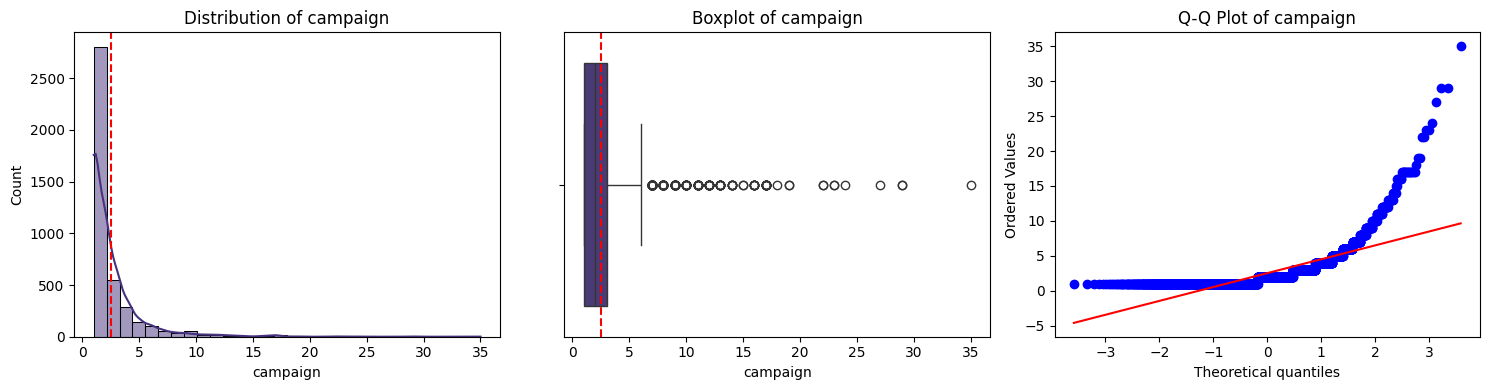

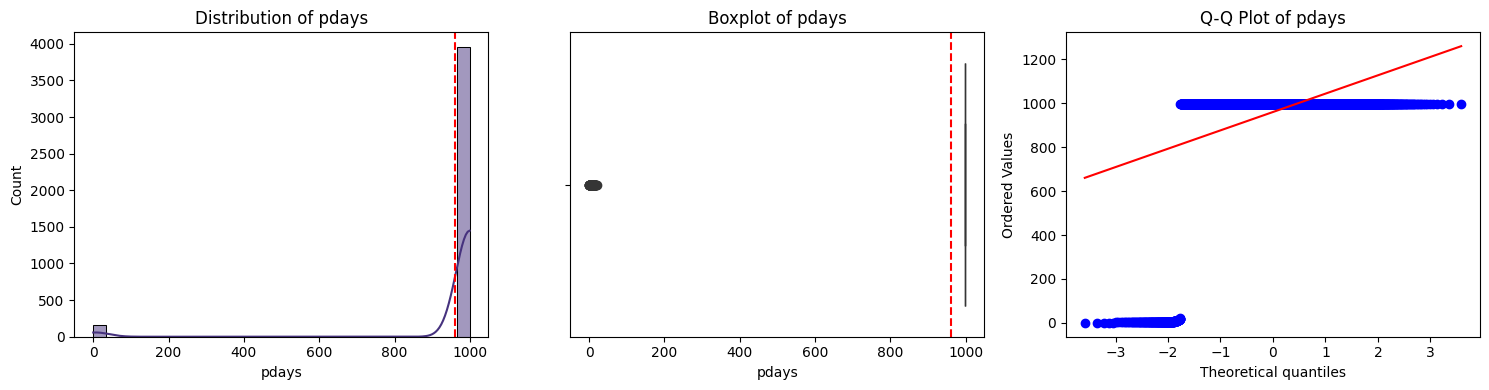

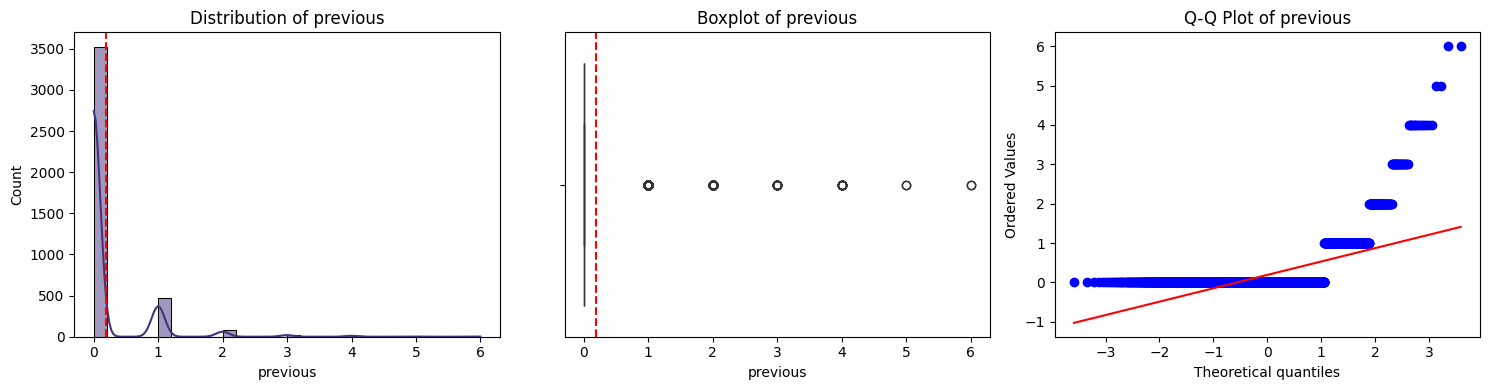

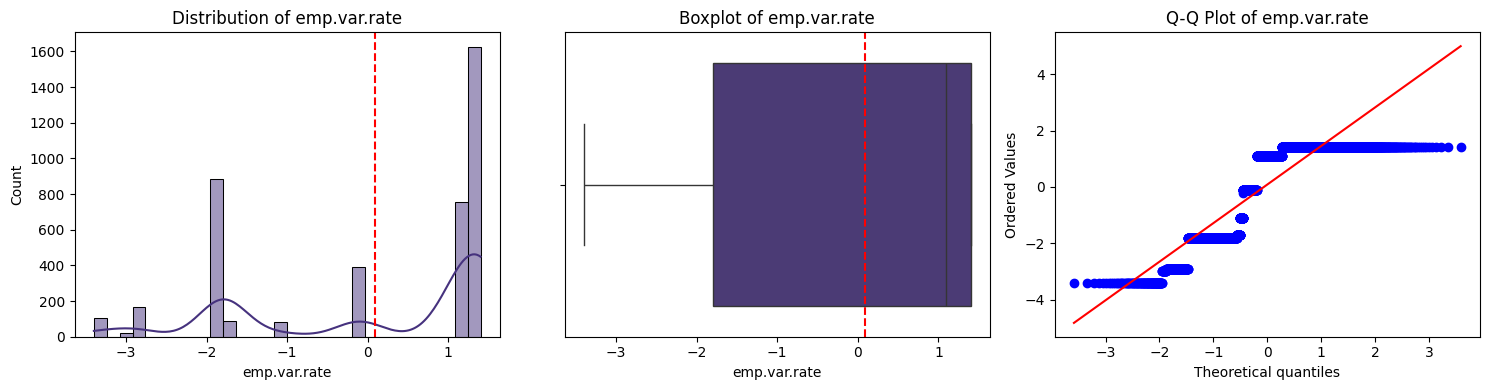

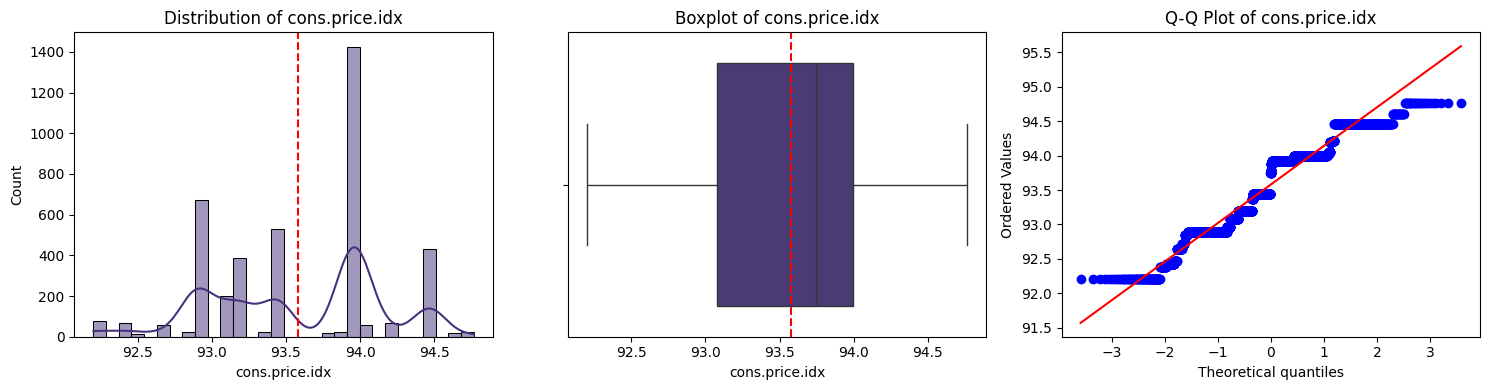

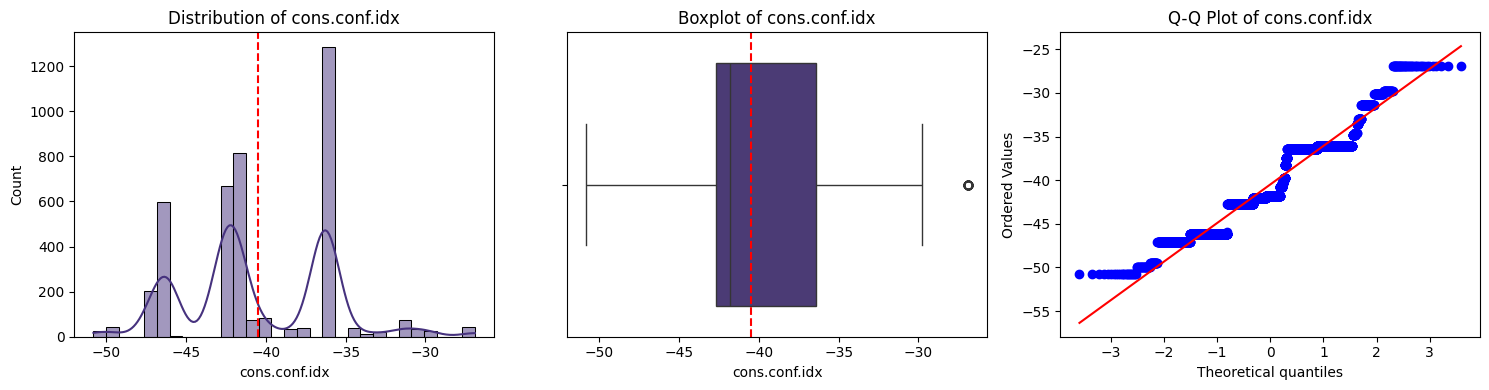

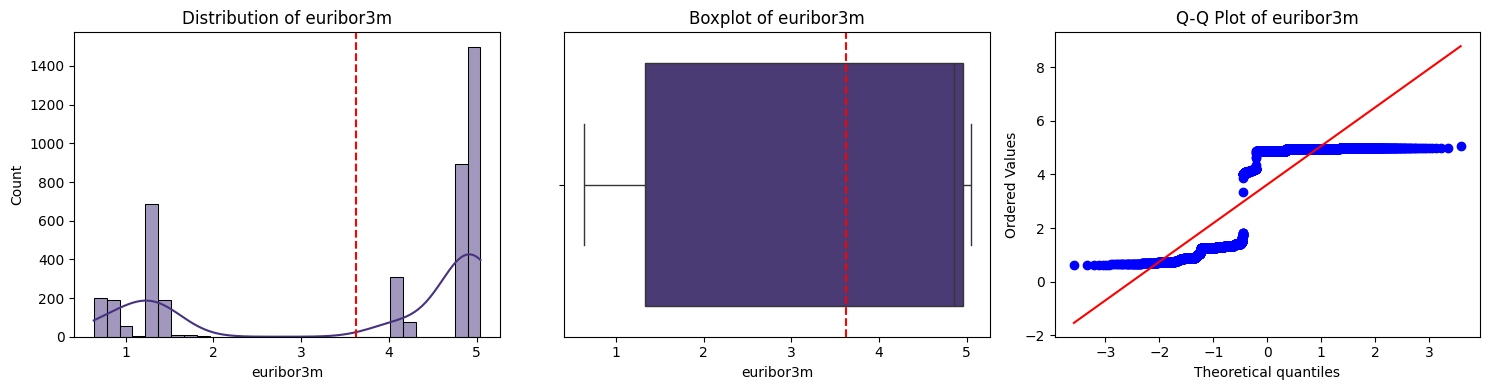

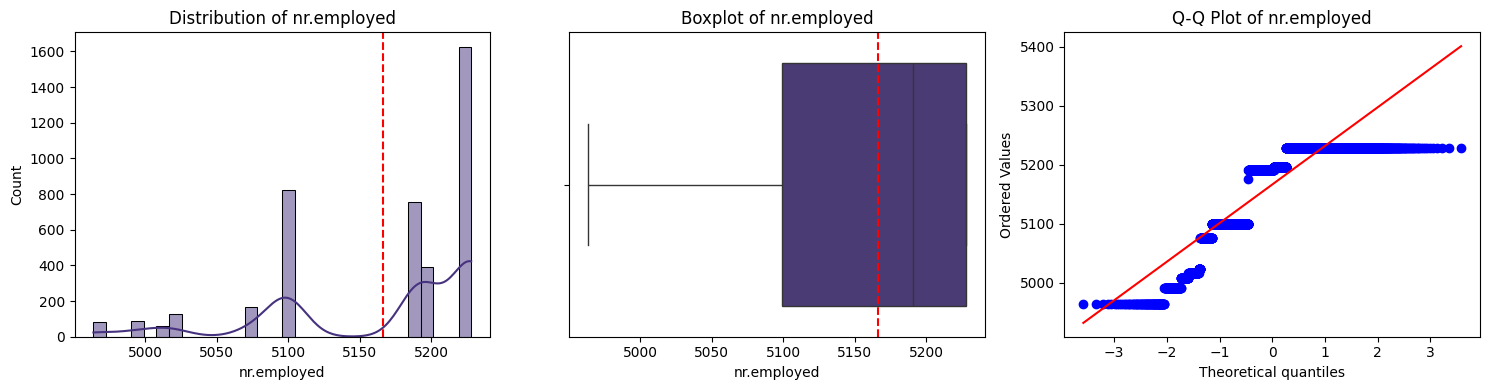

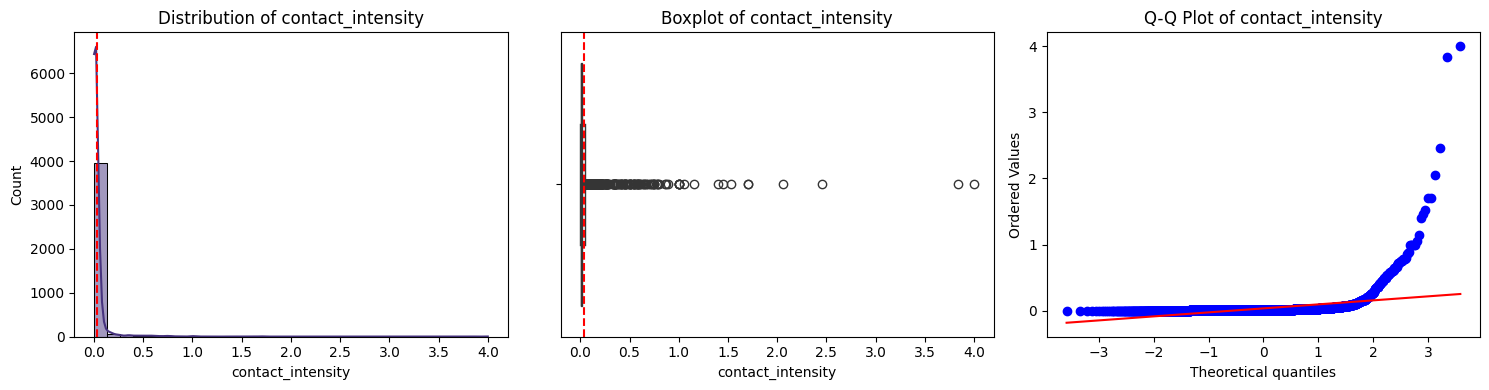

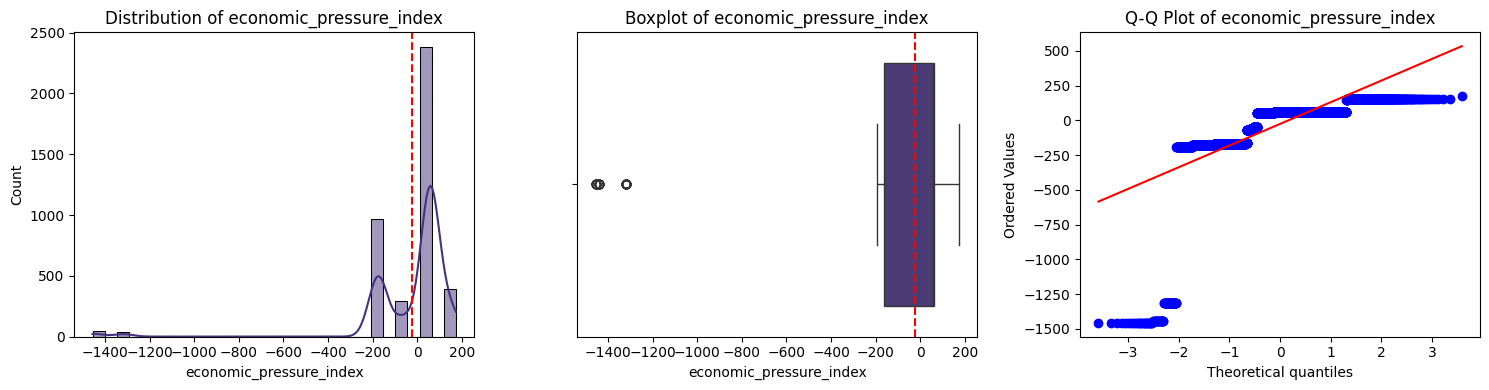


CATEGORICAL VARIABLES SUMMARY

job:
 job
admin.           1012
blue-collar       884
technician        691
services          393
management        324
retired           166
self-employed     159
entrepreneur      148
unemployed        111
housemaid         110
student            82
unknown            39
Name: count, dtype: int64

marital:
 marital
married     2509
single      1153
divorced     446
unknown       11
Name: count, dtype: int64

education:
 education
university.degree      1264
high.school             921
basic.9y                574
professional.course     535
basic.4y                429
basic.6y                228
unknown                 167
illiterate                1
Name: count, dtype: int64

default:
 default
no         3315
unknown     803
yes           1
Name: count, dtype: int64

housing:
 housing
yes        2175
no         1839
unknown     105
Name: count, dtype: int64

loan:
 loan
no         3349
yes         665
unknown     105
Name: count, dtype: int64

contact:

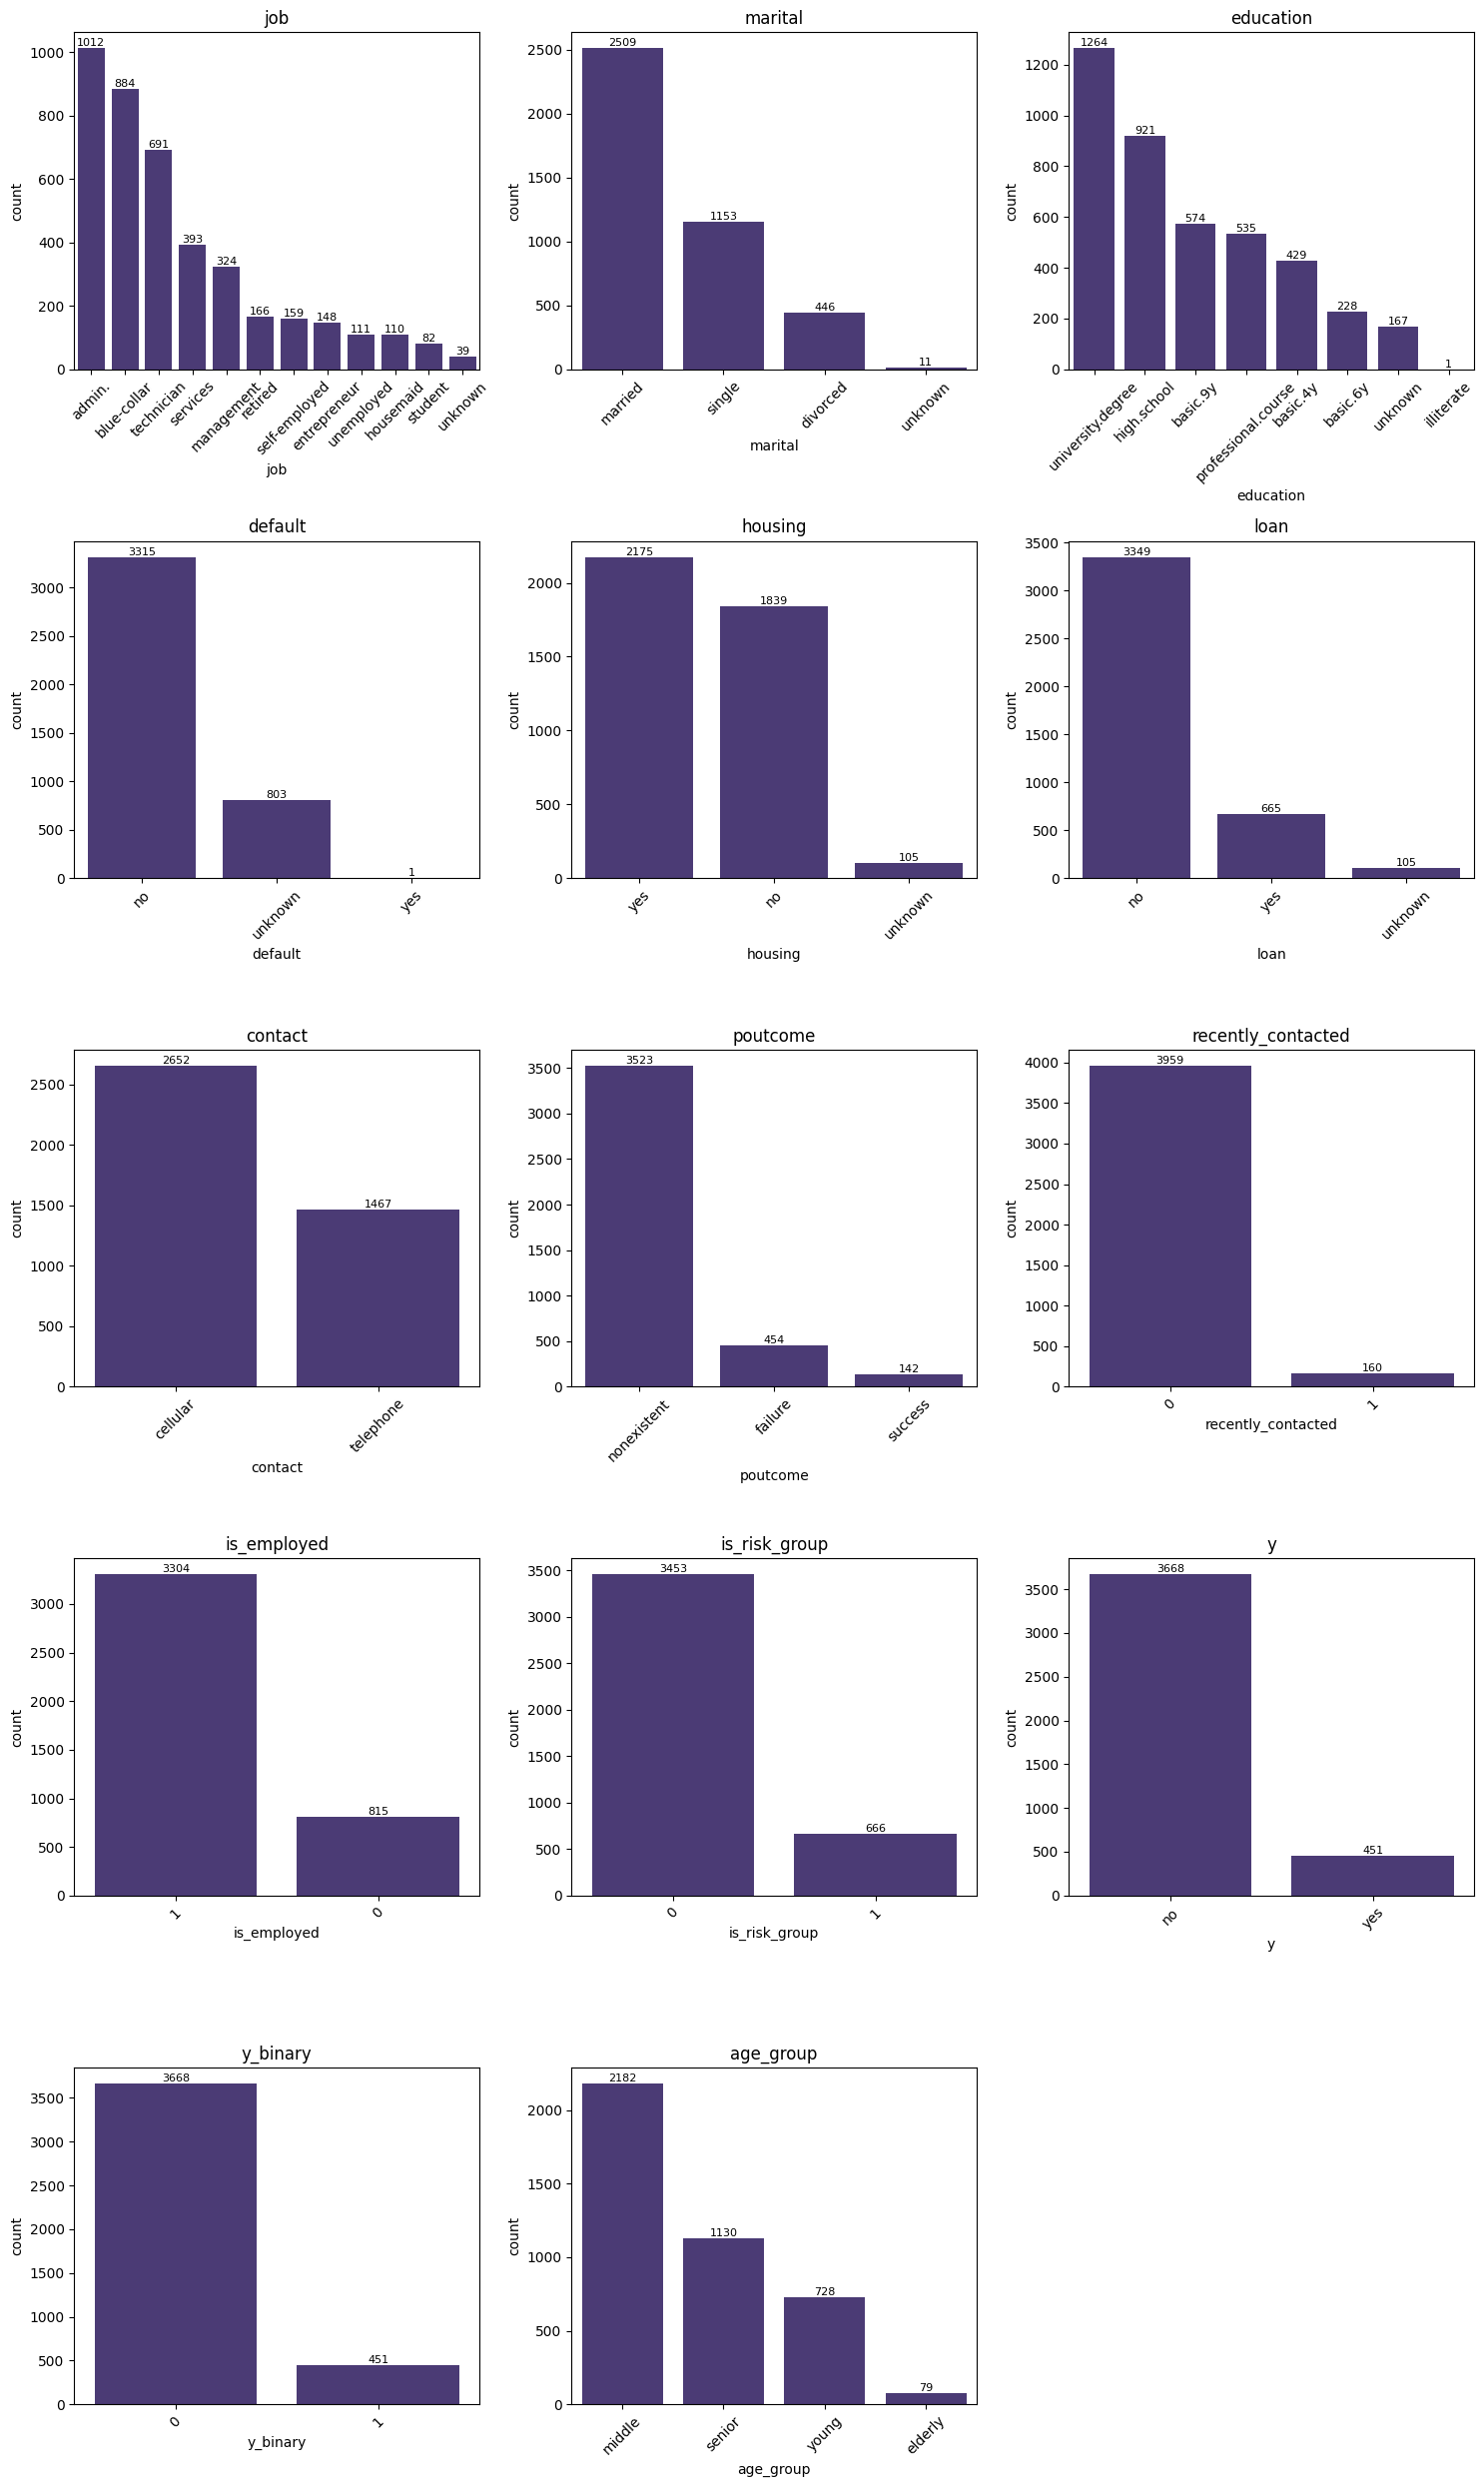


DATE VARIABLES ANALYSIS


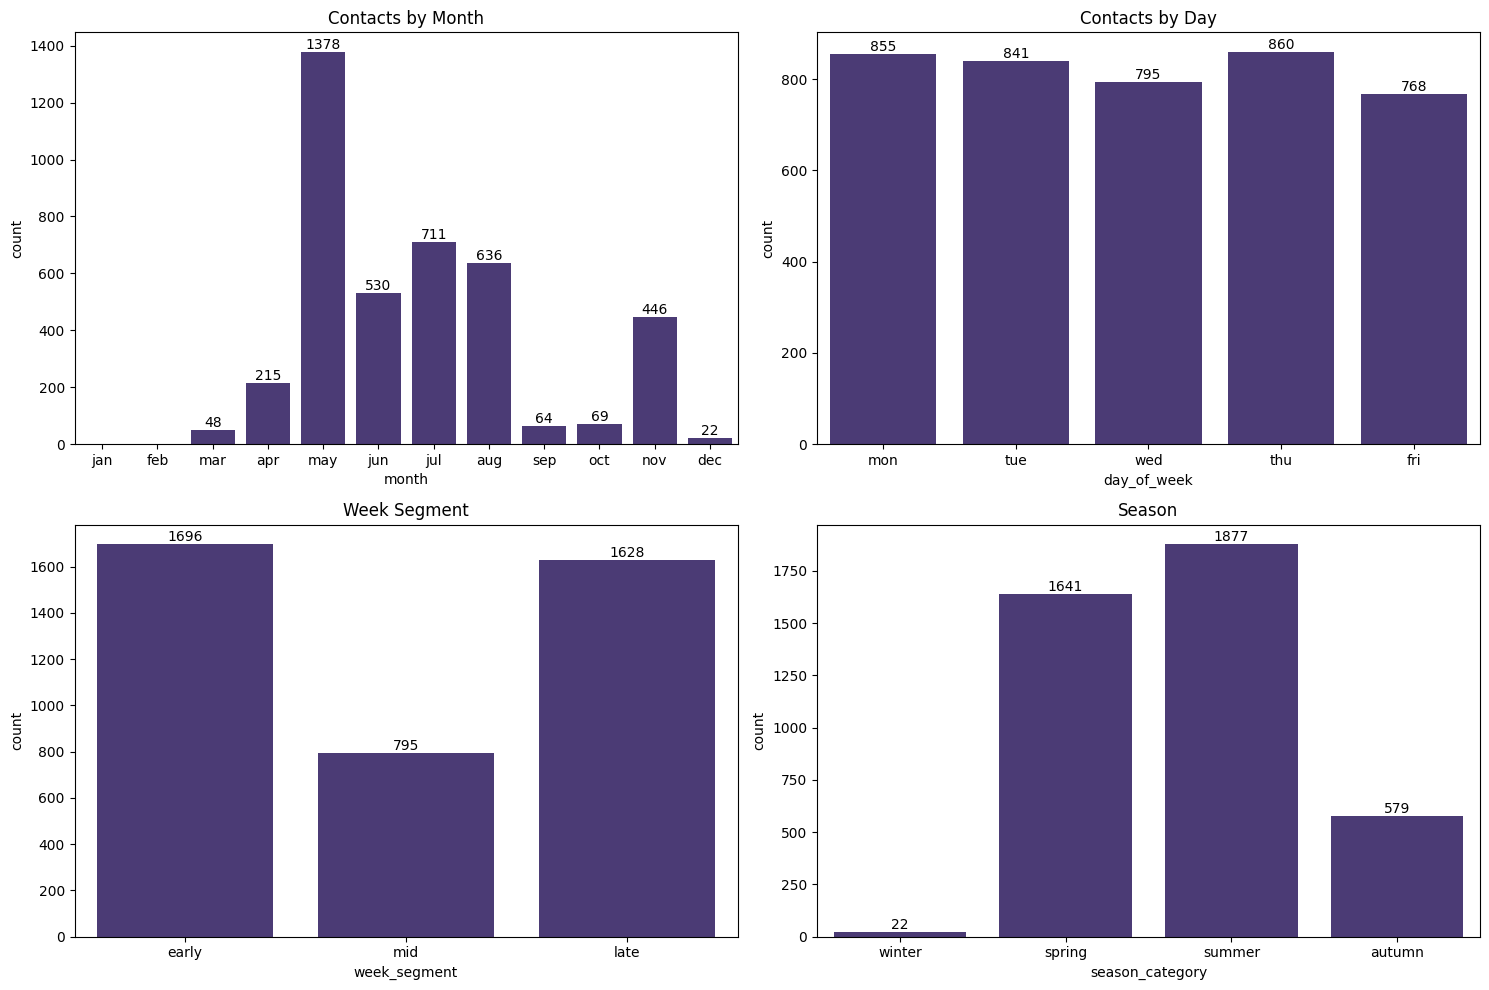


BIVARIATE ANALYSIS: NUMERIC VS TARGET


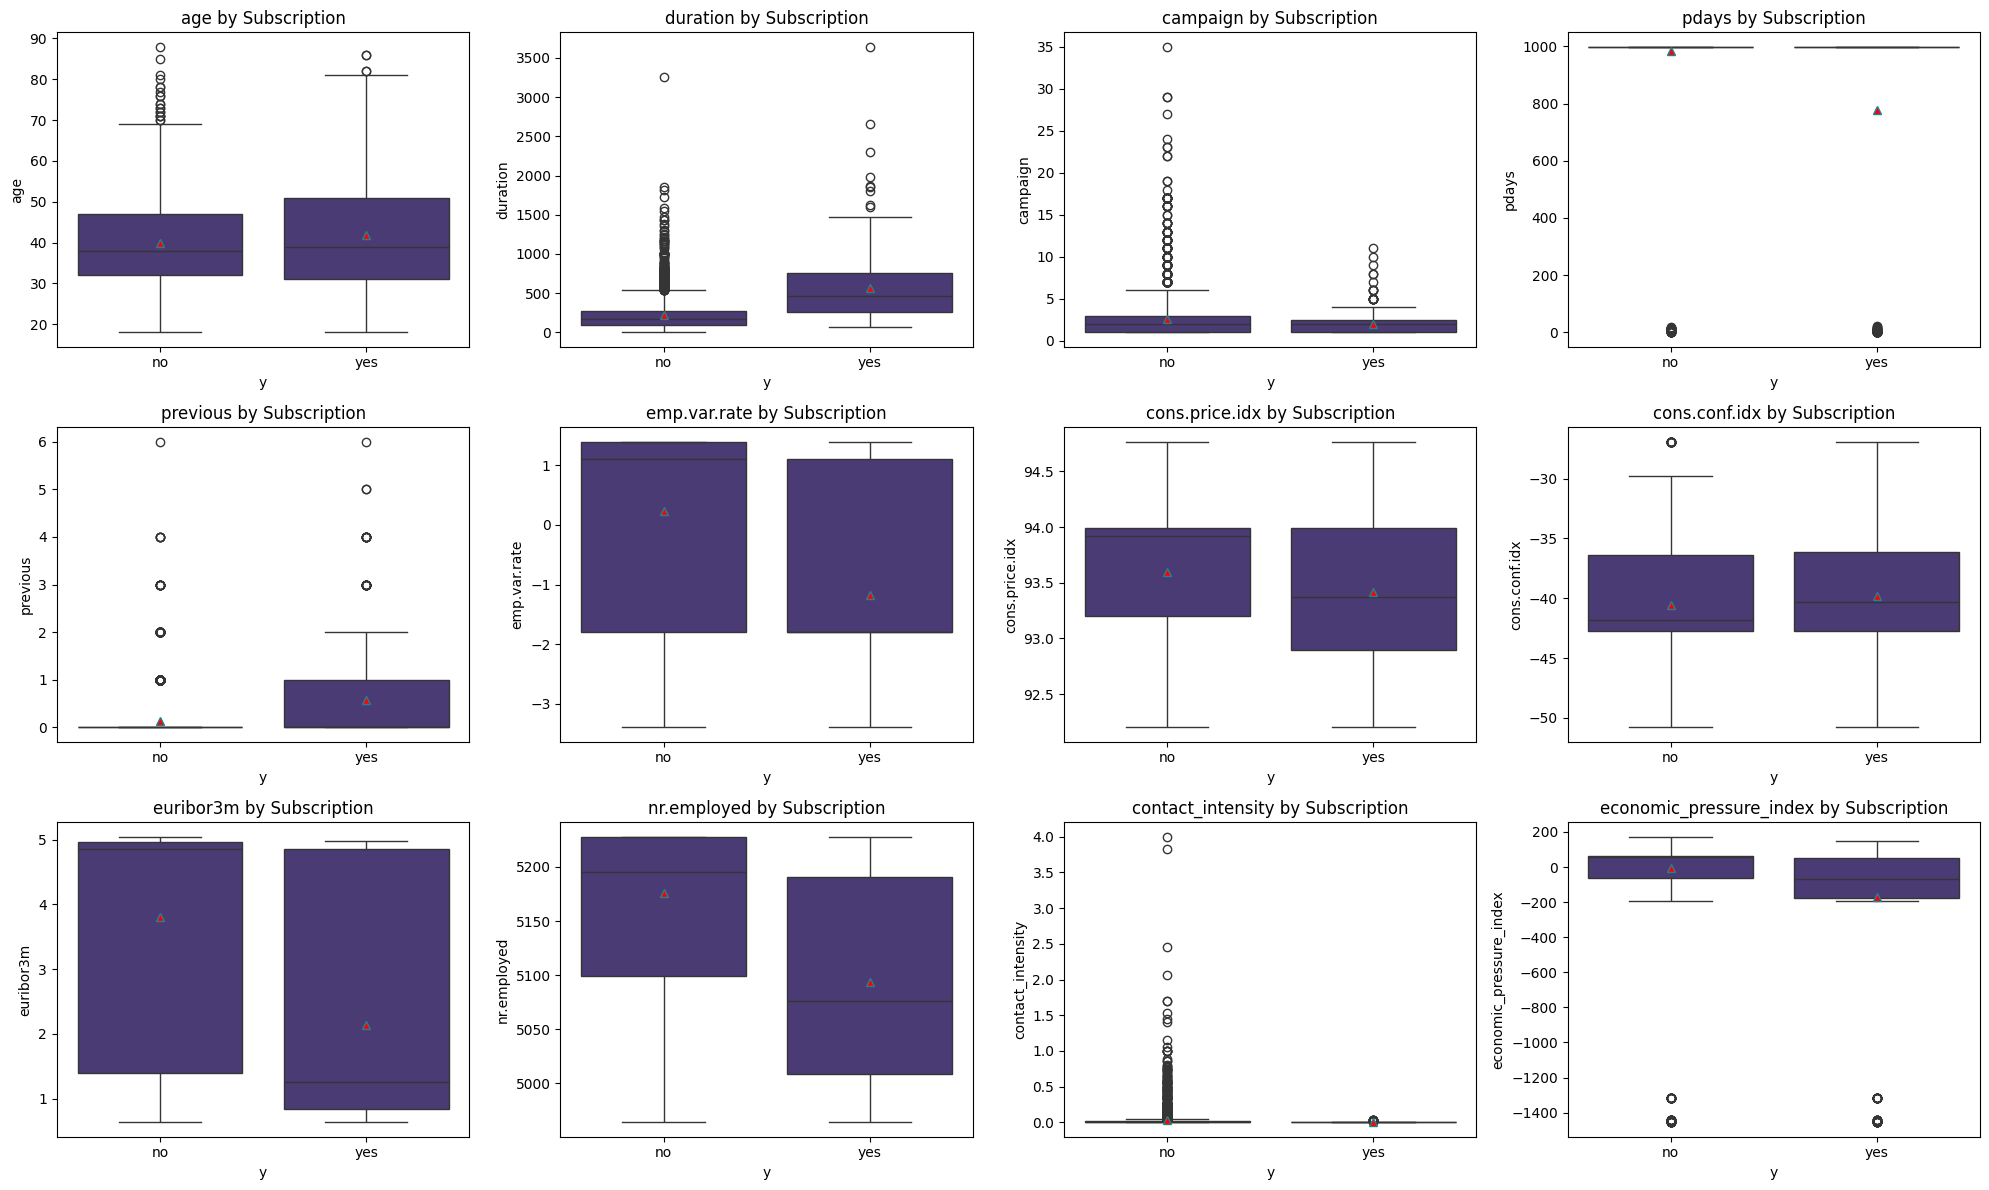


BIVARIATE ANALYSIS: CATEGORICAL VS TARGET


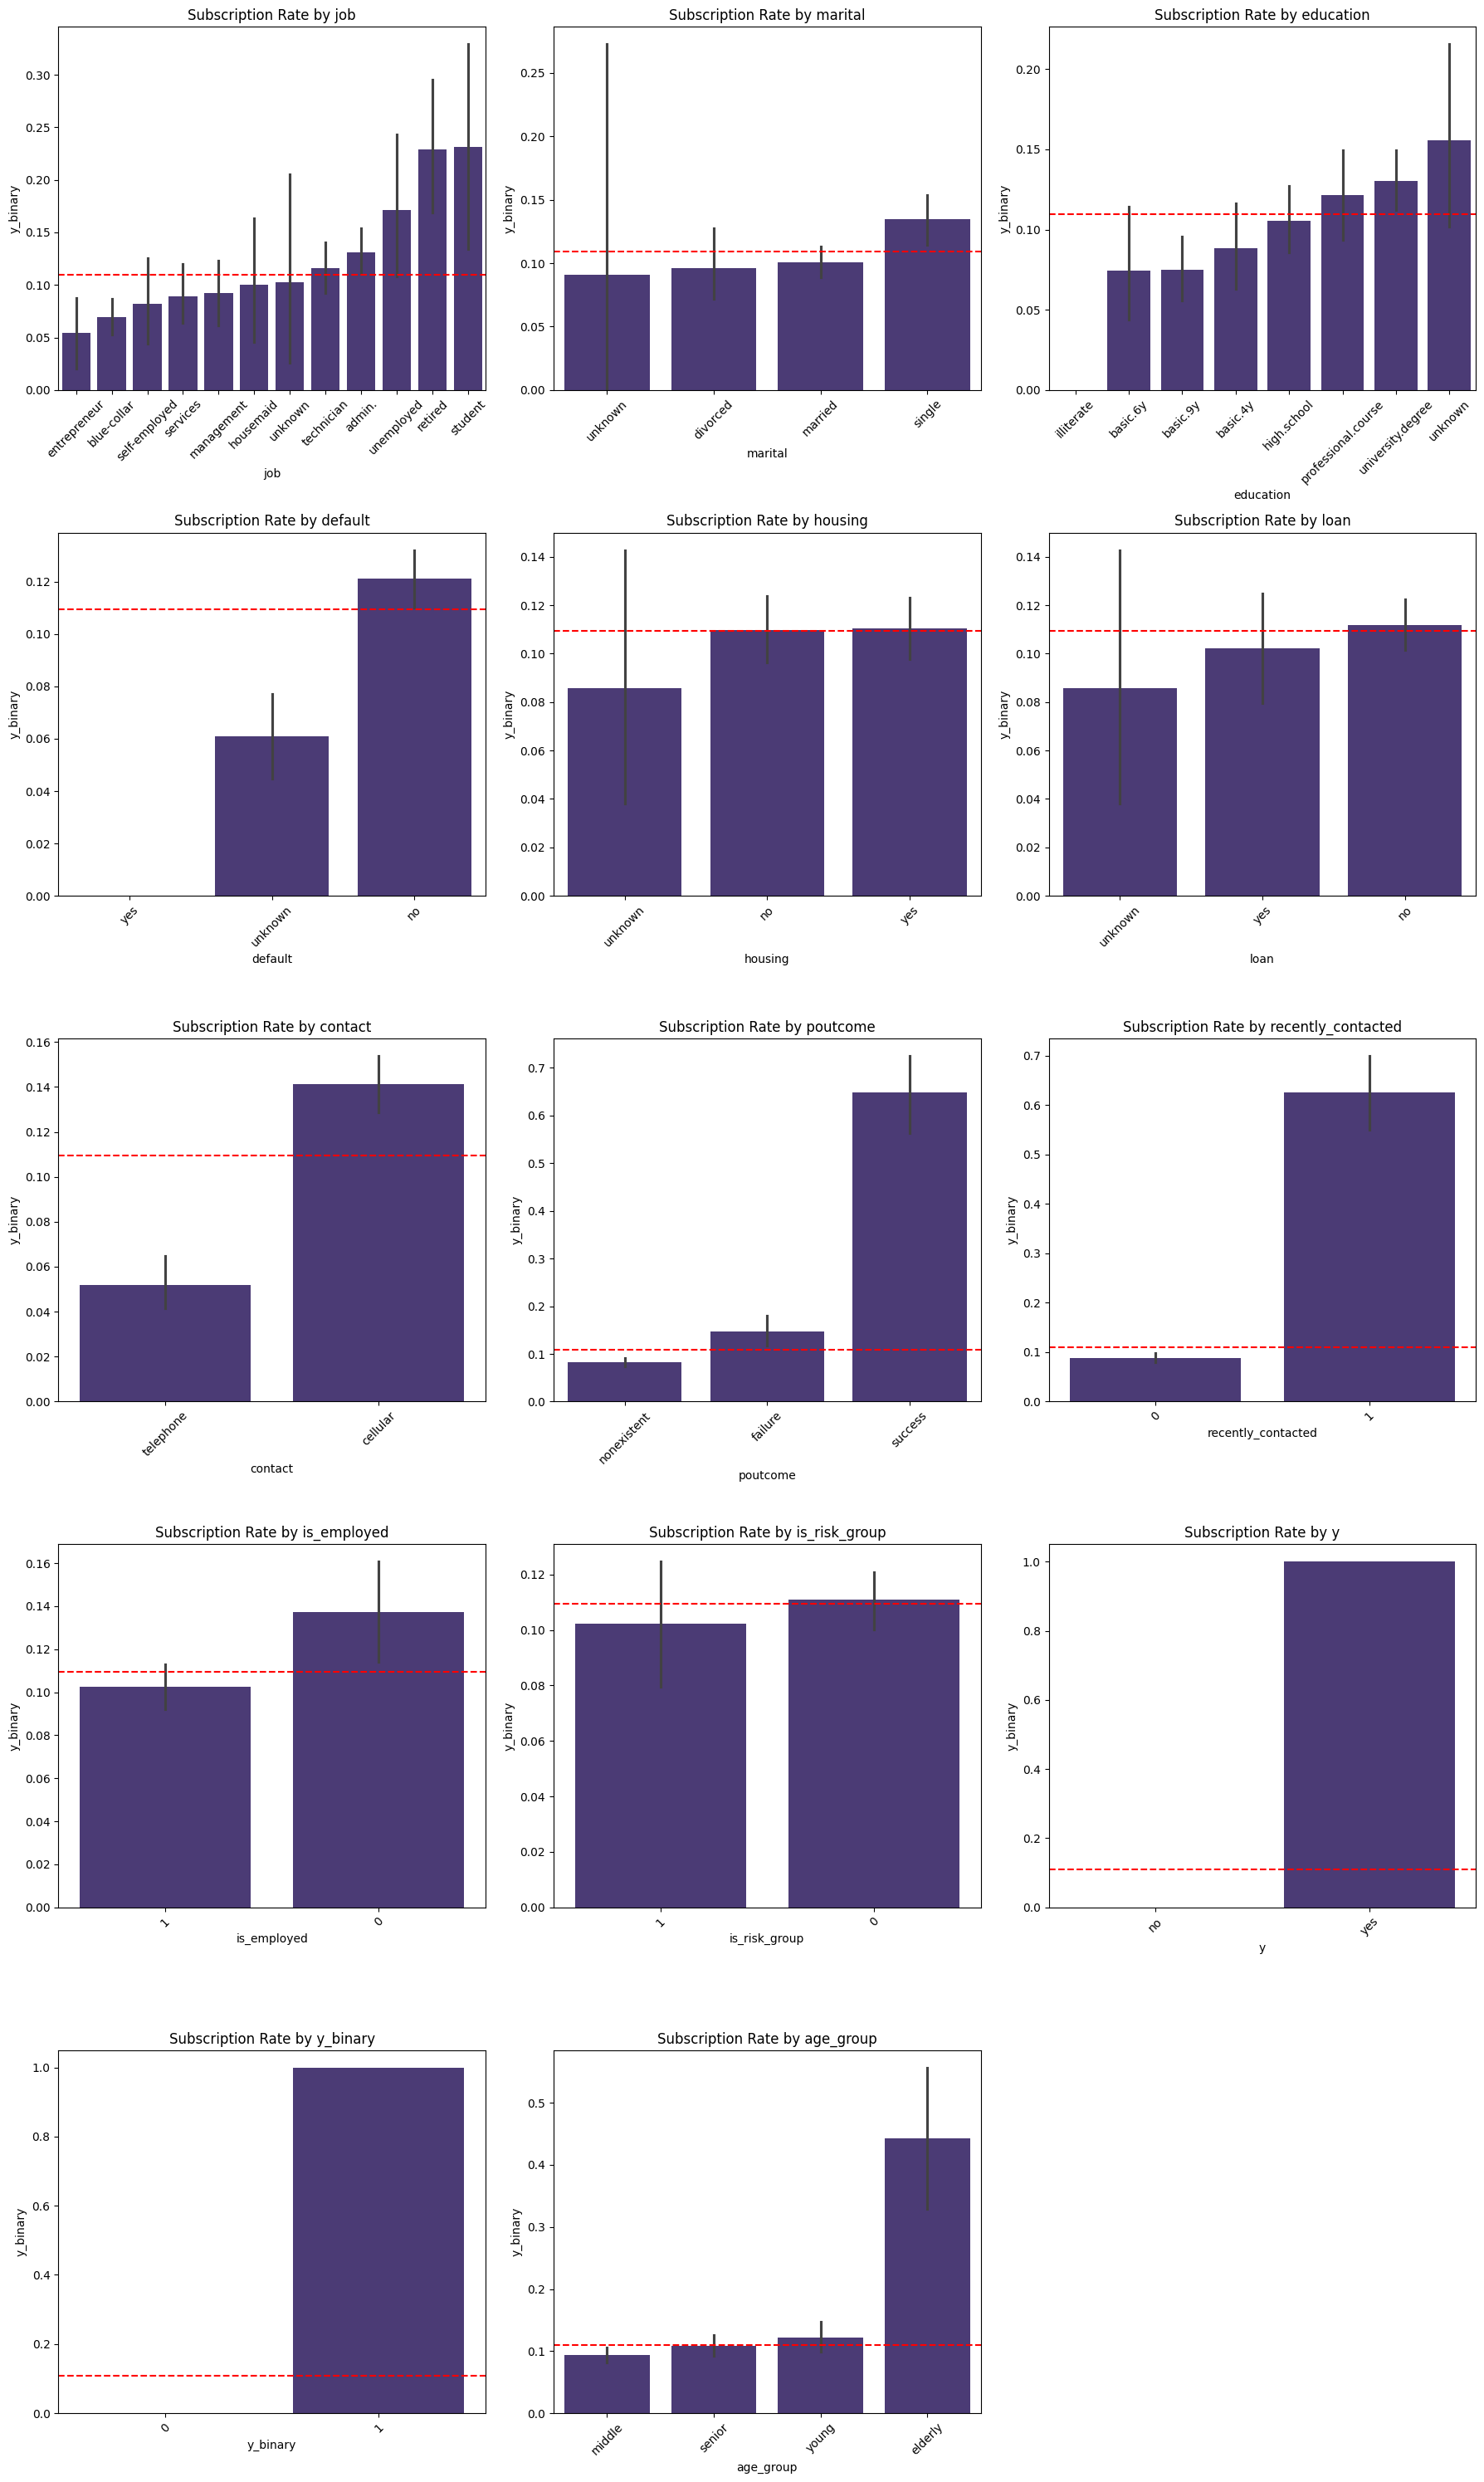


MULTIVARIATE ANALYSIS


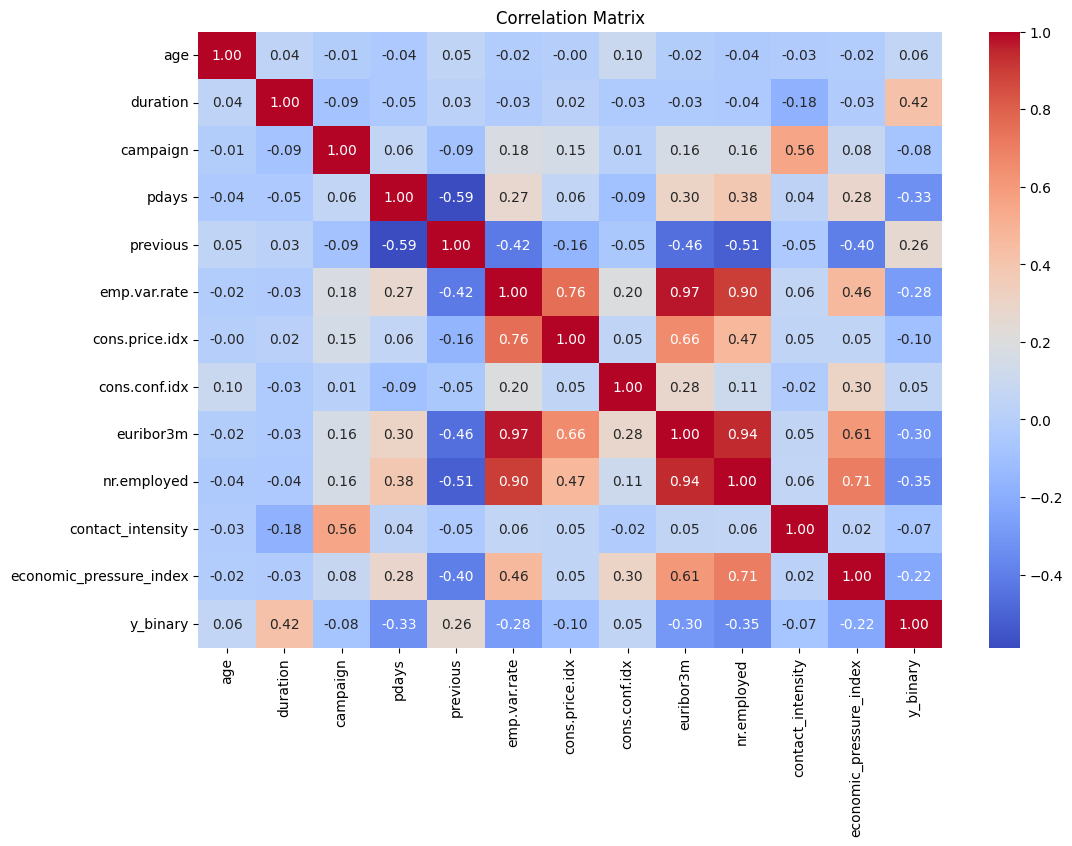


Top features by correlation with target:
duration                   0.418565
nr.employed                0.349241
pdays                      0.332012
euribor3m                  0.298565
emp.var.rate               0.283216
previous                   0.255697
economic_pressure_index    0.224844
cons.price.idx             0.098326
campaign                   0.076091
contact_intensity          0.072068
Name: y_binary, dtype: float64

CHI-SQUARE TEST RESULTS (p-values):
job: p = 0.0000
marital: p = 0.0163
education: p = 0.0023
default: p = 0.0000
housing: p = 0.7307
loan: p = 0.5684
contact: p = 0.0000
poutcome: p = 0.0000
recently_contacted: p = 0.0000
is_employed: p = 0.0053
is_risk_group: p = 0.5489
y: p = 0.0000
y_binary: p = 0.0000
age_group: p = 0.0000

DATASET INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  ----- 

In [ ]:
perform_eda(df)

#### Business And Statistical Insights

**Target Variable Analysis**
  - The target variable `y_binary` is highly imbalanced:
    - 3,668 customers (≈89%) did not subscribe
    - 451 customers (≈11%) did subscribe
  - This imbalance is important because it means most customers say "no" — so the model needs to be especially good at identifying the rare "yes" cases.

**Numerical Variables Analysis**

**Dataset Overview**
  - Summary statistics show:
    - `duration` (call length) ranges from 0 to 3643 seconds — very wide spread, with a median of 181 seconds.
    - `pdays` is 999 for most customers, meaning they were never contacted before — this value dominates the column.
    - `campaign` (number of contacts during this campaign) has a max of 35, but most customers were contacted 1–3 times.
    - `previous` (contacts in past campaigns) is 0 for most — very few customers were contacted before.

  - Outliers and skewness:
    - Variables like `duration`, `pdays`, and `economic_pressure_index` show strong skewness and outliers.
    - These may need transformation or special handling in modeling.

  - Distribution patterns:
    - `duration` is positively skewed — most calls are short, but a few are very long.
    - `euribor3m` and `nr.employed` are more normally distributed and show meaningful variation.

**Business Insights (Numerical)**
  - Longer calls are clearly linked to higher subscription rates — this suggests that meaningful conversations are more persuasive
  - Customers who were contacted recently or had previous interactions are more likely to say yes — follow-ups matter
  - Economic indicators like `euribor3m` (interest rate) and `emp.var.rate` (employment variation) influence decisions as customers can be more cautious in uncertain economic times

**Statistical Insights (Numerical)**
  - Top features correlated with subscription (y_binary):
    - `duration` (0.42): Strongest predictor — longer calls = higher chance of success.
    - `nr.employed` (0.35): Indicates that employment trends affect customer confidence.
    - `pdays` (0.33): Lower values (i.e., recent contact) are better.
    - `euribor3m` (0.30) and `emp.var.rate` (0.28): Reflect macroeconomic conditions.

**Categorical Variables Analysis**

**Dataset Overview**
  - Job types:
    - Most common: admin. (1,012), blue-collar (884), technician (691)
    - Least common: student (82), housemaid (110), unemployed (111)
  - Marital status:
    - Majority are married (2,509), followed by single (1,153)
  - Education:
    - Most have university degrees (1,264) or high school education (921)
  - Contact method:
    - Cellular (2,652) is more common than telephone (1,467)
  - Previous campaign outcome:
    - Most customers were never contacted before (poutcome = nonexistent)

**Business Insights (Categorical)**
  - Higher subscription rates seen among:
    - Students and retirees — possibly more time or interest in saving
    - Customers with successful past outcomes — trust and familiarity help
    - Those contacted via cellular — more personal and direct than landlines
  - Customers with unknown values in financial fields (like `default`) tend to convert less — may signal risk or lack of transparency

**Statistical Insights (Categorical)**
  - Chi-square test results show significant relationships (p < 0.05) between subscription and:
    - Job, marital status, education, default status, contact method, past outcome, recent contact, employment status, and age group
  - No significant relationship with:
    - Housing loan, personal loan, or risk group — these may not add much predictive value

**Multivariate Analysis**
  - Correlation matrix reveals:
    - Strong positive correlation between `euribor3m` and `nr.employed` — both reflecting economic health
    - Negative correlation between `emp.var.rate` and `pdays` — when the person isn't employed then there fewer follow-ups
  - These relationships help identify redundant features and guide feature selection

In [ ]:
# Auto-EDA
# d = dtale.show(df, ignore_duplicate=True, port=40001)
# d.open_browser()
# dtale.show()

## Data Preparation

#### Seperating Inputs And Outputs

Separating the dataframe into features (inputs) and the target (output).
Also identifies numerical and categorical features within the inputs.

Args:
* df (pd.DataFrame): The input dataframe.
* target_column (str): The name of the target column.

Returns:
* tuple: A tuple containing:
  * X (pd.DataFrame): DataFrame containing the features.
  * y (pd.Series): Series containing the target variable.
  * numeric_feats (list): List of numerical feature names.
  * categorical_feats (list): List of categorical feature names.

In [ ]:
# Seperating Inputs And Outputs
def separate_inputs_outputs(df, target_column='y_binary'):
    print("\n" + "*"*50)
    print("SEPARATING INPUTS AND OUTPUTS")
    print("*"*50)

    # Define target variable
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in the dataframe.")
    y = df[target_column]

    # Define features (excluding target and any other columns to be dropped before modeling, e.g., 'duration', 'y')
    columns_to_drop = [target_column, 'y_binary', 'y', 'duration', 'contact_intensity']
    # Add other columns to drop here if needed
    x = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    # Identify numerical and categorical features in the remaining columns (X)
    numeric_feats = x.select_dtypes(include=np.number).columns.tolist()
    categorical_feats = x.select_dtypes(include='object').columns.tolist()

    print(f"Features (x) shape: {x.shape}")
    print(f"Target (y) shape: {y.shape}")
    print(f"Numeric features ({len(numeric_feats)}): {numeric_feats}")
    print(f"Categorical features ({len(categorical_feats)}): {categorical_feats}")

    return x, y, numeric_feats, categorical_feats

In [ ]:
x, y, numeric_features, categorical_features = separate_inputs_outputs(df)


**************************************************
SEPARATING INPUTS AND OUTPUTS
**************************************************
Features (x) shape: (4119, 26)
Target (y) shape: (4119,)
Numeric features (13): ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'recently_contacted', 'is_employed', 'is_risk_group', 'economic_pressure_index']
Categorical features (12): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'week_segment', 'season_category']


####Pre-Processing Pipline Set-up

Building a preprocessing pipeline for numerical and categorical features.
Args:
* numeric_feats (list): List of names of numerical features.
* categorical_feats (list): List of names of categorical features.

Returns:
* ColumnTransformer: A fitted ColumnTransformer object.


In [ ]:
def build_preprocessing_pipeline(numeric_feats, categorical_feats):
    # Identify features that should NOT go through Winsorizer
    # These are likely binary features or features where outlier capping is not appropriate
    # Also excluding pdays and previous due to low variation with IQR method
    exclude_from_winsorizer = ['recently_contacted', 'is_employed', 'is_risk_group', 'pdays', 'previous']

    # Separate numerical features into those needing winsorization and those that don't
    numeric_feats_for_winsorizer = [feat for feat in numeric_feats if feat not in exclude_from_winsorizer]
    numeric_feats_without_winsorizer = [feat for feat in numeric_feats if feat in exclude_from_winsorizer]


    # Numerical pipeline for features needing winsorization: impute, winsorize outliers, and scale
    num_pipe_winsor = Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('winsorize', Winsorizer(capping_method='iqr', tail='both', fold=1.5)),
        ('scale', MinMaxScaler())
    ])

    # Numerical pipeline for binary-like features and others excluded from winsorizer: impute and scale (no winsorization)
    num_pipe_no_winsor = Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', MinMaxScaler()) # Scale them like other numerics
    ])


    # Categorical pipeline: impute 'unknown' with mode, and one-hot encode
    cat_pipe = Pipeline([
         ('impute_unknown', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
        ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine pipelines using ColumnTransformer
    # Ensure all identified categorical features are passed to the 'cat' transformer
    preprocess = ColumnTransformer(transformers=[
        ('num_winsor', num_pipe_winsor, numeric_feats_for_winsorizer),
        ('num_no_winsor', num_pipe_no_winsor, numeric_feats_without_winsorizer),
        ('cat', cat_pipe, categorical_feats)
    ], remainder='drop')

    return preprocess

In [ ]:
preprocessing_pipeline = build_preprocessing_pipeline(numeric_features, categorical_features)
preprocessing_pipeline

ColumnTransformer(transformers=[('num_winsor',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('winsorize',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5,
                                                             tail='both')),
                                                 ('scale', MinMaxScaler())]),
                                 ['age', 'campaign', 'emp.var.rate',
                                  'cons.price.idx', 'cons.conf.idx',
                                  'euribor3m', 'nr.employed',
                                  'economic_pressure_index']),
                                ('num_no_winsor',
                                 Pipeline(steps=[('impute', Sim...
                                 ['pdays', 'previous', 'recently_contacted',
                                  'is_employed', 'is_risk_group']),
                                ('cat',
                                 Pipeline(steps=[('impute_unknown',
                                                  SimpleImputer(missing_values='unknown',
                                                                strategy='most_frequent')),
                                                 ('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'day_of_week', 'poutcome', 'week_segment',
                                  'season_category'])])

#### Pipline Setup Insights

**Numeric features** are divided into two groups:
  - Features like `age`, `campaign`, and `euribor3m` go through:
    - Mean imputation for missing values
    - Winsorization to cap extreme outliers using the IQR method
    - Min-max scaling to bring values into a 0–1 range
  - Binary or low-variance features like `recently_contacted`, `is_employed`, `pdays`, and `previous` are:
    - Imputed using the mean
    - Scaled without applying outlier treatment

**Categorical features** such as `job`, `education`, and `contact` are:
  - Imputed by replacing 'unknown' values with the most frequent category (mode)
  - One-hot encoded to convert them into numerical format which is suitable for modeling

- All transformations are combined using a ColumnTransformer, ensuring that each feature is processed appropriately and consistently.

This ensures that the data is clean, scaled, and free from outliers or missing value issues.

#### Feature Selection

**Feature Selection**

Performing feature selection using SelectKBest within a pipeline and saves the pipeline.

Args:
* x (pd.DataFrame): Feature dataframe.
* y (pd.Series): Target series.
* preprocess (ColumnTransformer): The preprocessing pipeline before feature selection.
* k (int): The number of top features to select.
* filename (str): The filename to save the pipeline.

Returns:
* np.ndarray: The feature-selected transformed feature matrix.
* Pipeline: The fitted full pipeline including preprocessing and feature selection.

In [ ]:
# Feature Selection
def select_features_and_save(x, y, preprocess, k=20, filename='wind_turbine_prep_pipeline.joblib'):

  print("\n" + "*"*50)
  print("PERFORMING FEATURE SELECTION AND SAVING PIPELINE")
  print("*"*50)

  # Create the feature selection step
  selector = SelectKBest(score_func=f_classif, k=k)

  # Build the full pipeline including preprocessing and feature selection
  full_pipe = Pipeline([
      ('prep',  preprocess),
      ('fs',    selector)
  ])

  # Fit-transform once to obtain clean feature matrix with selected features
  print(f"Fitting and transforming data with k={k} features...")
  x_selected = full_pipe.fit_transform(x, y)
  print(f"Shape of feature-selected data: {x_selected.shape}")

  # Persist the full pipeline for production reuse
  print(f"Saving full pipeline to '{filename}'...")
  joblib.dump(full_pipe, filename)
  print("Pipeline saved successfully.")

  return x_selected, full_pipe

In [ ]:
x_selected, full_pipeline = select_features_and_save(x, y, preprocessing_pipeline, k=20, filename='bank_marketing_prep_pipeline.joblib')
x_selected, full_pipeline


**************************************************
PERFORMING FEATURE SELECTION AND SAVING PIPELINE
**************************************************
Fitting and transforming data with k=20 features...
Shape of feature-selected data: (4119, 20)
Saving full pipeline to 'bank_marketing_prep_pipeline.joblib'...
Pipeline saved successfully.


(array([[0.2       , 0.33333333, 0.26968044, ..., 1.        , 0.        ,
         0.        ],
        [0.6       , 0.9375    , 0.69875292, ..., 1.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.88230709, ..., 1.        , 0.        ,
         0.        ],
        ...,
        [0.2       , 0.33333333, 0.26968044, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.48441154, ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.6875    , 0.3893219 , ..., 1.        , 0.        ,
         0.        ]]),
 Pipeline(steps=[('prep',
                  ColumnTransformer(transformers=[('num_winsor',
                                                   Pipeline(steps=[('impute',
                                                                    SimpleImputer()),
                                                                   ('winsorize',
                                                                    Winso

#### Business And Statistical Insights

**What Was Done**
  - Applied a feature selection technique using **SelectKBest** to retain the top 20 most relevant features for predicting customer subscription
  - The selection was based on statistical tests that measure how strongly each feature is related to the target variable.
  - The full preprocessing and feature selection pipeline was saved as a reusable file: `'bank_marketing_prep_pipeline.joblib'`.

**Statistical Insight**
  - The transformed dataset now has 20 features — reducing dimensionality while keeping the most informative variables
  - This helps:
    - Improve model performance by removing noise
    - Reduce overfitting
    - Speed up training and prediction

**Business Insight**
  - By focusing only on the most predictive features, the model becomes more efficient and interpretable.
  - Bank can better understand which customer traits or behaviors truly influence subscription decisions — leading to smarter targeting and more effective campaigns.

In [ ]:
# Savinng the bank_preprocessed_data file
bank_preprocessed_data = pd.DataFrame(x_selected)
bank_preprocessed_data.to_csv('bank_preprocessed_data.csv', index=False)
print("Processed data saved as 'bank_preprocessed_data.csv'")

Processed data saved as 'bank_preprocessed_data.csv'


## Data Split And Balancing

#### Splitting Into Training And Test

Spliting data into training and testing sets and applies SMOTE to the training set.

Args:
* x (np.ndarray or pd.DataFrame): The feature data.
* y (pd.Series): The target variable.
* test_size (float): The proportion of the dataset to include in the test split.
* random_state (int): Controls the shuffling applied to the data before applying the split.

Returns:
* tuple: A tuple containing:
  * x_train (np.ndarray): Training features.
  * x_test (np.ndarray): Testing features.
  * y_train (np.ndarray): Training target.
  * y_test (np.ndarray): Testing target.


In [ ]:
# Splitting The Data Into Train And Test
def split_data_and_balance(x, y, test_size=0.20, random_state=42):

  print("\n" + "*"*50)
  print("DATA SPLIT AND BALANCING")
  print("*"*50)

  # Ensure x is a numeric NumPy array
  x = np.asarray(x, dtype=float)

  # Split data
  print(f"Splitting data into training ({1-test_size:.0%}) and testing ({test_size:.0%}) sets...")
  x_train, x_test, y_train, y_test = train_test_split(
      x, y, test_size=test_size, random_state=random_state, stratify=y
  )
  print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
  print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

  # Apply SMOTE to balance the training set
  print("Applying SMOTE to the training data...")
  smote = SMOTE(random_state=random_state)
  x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)
  print(f"X_train shape after SMOTE: {x_train_balanced.shape}, y_train shape after SMOTE: {y_train_balanced.shape}")
  print(f"Training target distribution after SMOTE:\n{pd.Series(y_train_balanced).value_counts()}")

  return x_train_balanced, x_test, y_train_balanced, y_test

In [ ]:
x_train, x_test, y_train, y_test = split_data_and_balance(x_selected, y)


**************************************************
DATA SPLIT AND BALANCING
**************************************************
Splitting data into training (80%) and testing (20%) sets...
x_train shape: (3295, 20), y_train shape: (3295,)
x_test shape: (824, 20), y_test shape: (824,)
Applying SMOTE to the training data...
X_train shape after SMOTE: (5868, 20), y_train shape after SMOTE: (5868,)
Training target distribution after SMOTE:
y_binary
1    2934
0    2934
Name: count, dtype: int64


#### Business And Statistical Insights

**What Was Done**
- The dataset was split into:
  - 80% for training (3,295 records)
  - 20% for testing (824 records)
- The training data was imbalanced (fewer "yes" responses), so **SMOTE** (Synthetic Minority Over-sampling Technique) was applied to balance it.
- After SMOTE:
  - Training set size increased to 5,868 records
  - Equal number of positive (1) and negative (0) cases: 2,934 each

**Statistical Insight**
- SMOTE created synthetic examples of the minority class (subscribers) by interpolating between existing ones
- This helps the model learn patterns from both classes equally, rather than being biased toward the majority class
- Balanced training data improves the model’s ability to detect rare but important outcomes (like a customer saying "yes").

**Business Insight**
  - In real campaigns, only a small percentage of customers subscribe — but those are the most valuable.
  - Balancing the training data ensures the model doesn’t ignore these valuable customers.
  - This leads to better targeting, higher conversion rates, and more efficient use of marketing resources.

## Model Building And Tuning

#### Training And Tuning

Builds, tunes, and evaluates various classification models.

* Args:
  * x_train (np.ndarray): Training features.
  * y_train (np.ndarray): Training target.
  * x_test (np.ndarray): Testing features.
  * y_test (np.ndarray): Testing target.

* Returns:
  * dict: A dictionary containing evaluated results for each model.


In [ ]:
# Building and Tuning The Model
def build_and_tune_models(x_train, y_train, x_test, y_test):
    print("\n" + "*"*50)
    print("MODEL BUILDING AND TUNING")
    print("*"*50)

    models = {
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=40),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 10, 100]
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(class_weight='balanced', random_state=40),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 5, 10, 15]
            }
        },
        'Gradient Boosting': {
            'model': GradientBoostingClassifier(random_state=40),
            'params': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 4, 5]
            }
        },
        'K-Nearest Neighbors': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': list(range(3, 20, 2))
            }
        }
    }

    results = {}
    best_estimators = {}

    for name, model_info in models.items():
        print(f"\nTraining and tuning {name}...")
        grid_search = GridSearchCV(
            model_info['model'],
            model_info['params'],
            cv=5,
            scoring='f1',
            verbose=1,
            n_jobs=-1
        )
        grid_search.fit(x_train, y_train)

        best_model = grid_search.best_estimator_
        best_estimators[name] = best_model

        y_pred = best_model.predict(x_test)
        y_proba = best_model.predict_proba(x_test)[:, 1]

        results[name] = {
            'Best_model': best_model,
            'Best_params': grid_search.best_params_,
            'Cv_f1_score': grid_search.best_score_,
            'Test_accuracy': accuracy_score(y_test, y_pred),
            'Test_precision': precision_score(y_test, y_pred),
            'Test_recall': recall_score(y_test, y_pred),
            'Test_f1_score': f1_score(y_test, y_pred),
            'Test_roc_auc': roc_auc_score(y_test, y_proba),
            'Confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Test F1 score: {results[name]['Test_f1_score']:.4f}")

        filename = f'bank_marketing_{name.lower().replace(" ","_")}.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(best_model, f)
        print(f"{name} model saved to '{filename}'.")

    return results, best_estimators

In [ ]:
# Run model building
model_results, best_models = build_and_tune_models(x_train, y_train, x_test, y_test)


**************************************************
MODEL BUILDING AND TUNING
**************************************************

Training and tuning Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Logistic Regression: {'C': 0.01}
Test F1 score: 0.3889
Logistic Regression model saved to 'bank_marketing_logistic_regression.pkl'.

Training and tuning Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Test F1 score: 0.3593
Random Forest model saved to 'bank_marketing_random_forest.pkl'.

Training and tuning Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}
Test F1 score: 0.3924
Gradient Boosting model saved to 'bank_marketing_gradient_boosting.pkl'.

Training and tuning K-Nearest Neighbors...
Fitting 5 f

#### Business And Statistical Insights

**What Was Done**
  - 4 machine learning models were trained and tuned:
    - Logistic Regression
    - Random Forest
    - Gradient Boosting
    - K-Nearest Neighbors (KNN)
  - Each model was evaluated using the F1 score, which balances precision and recall — especially important for imbalanced datasets.
  - The best model parameters were selected based on cross-validation performance.
  - Final models were tested on unseen data and saved for future use.

**Statistical Insight**
  - Best F1 scores on the test set:
    - K-Nearest Neighbors: 0.4368
    - Gradient Boosting: 0.3924
    - Logistic Regression: 0.3889
    - Random Forest: 0.3593
  - KNN performed best in terms of F1 score, implying that it captured the balance between false positives and false negatives more effectively than the others
  - Each model was tuned using a range of hyperparameters:
    - Logistic Regression: regularization strength (C)
    - Random Forest: number of trees and tree depth
    - Gradient Boosting: learning rate, tree depth, and number of trees
    - KNN: number of neighbors

**Business Insight**
  - Different models offer different strengths:
    - KNN may be more sensitive to local patterns in customer behavior.
    - Gradient Boosting and Logistic Regression provide more interpretable decision boundaries.
  - By comparing multiple models, the bank can choose the one that best balances accuracy and interpretability for campaign targeting.
  - Saving the models ensures they can be reused for real-time predictions or further analysis without retraining.

## Evaluation

#### Model Evaluation

Evaluates a trained classification model and prints key metrics.

* Args:
  * model: A trained scikit-learn classification model.
  * x_test (np.ndarray or pd.DataFrame): The test features.
  * y_test (np.ndarray or pd.Series): The true test target values.
  * model_name (str): The name of the model for display purposes.

In [ ]:
def evaluate_model(model, x_test, y_test, model_name="Model"):
    print("\n" + "*"*50)
    print(f"EVALUATION FOR {model_name.upper()}")
    print("*"*50)

    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print("  Confusion Matrix:\n", cm)

    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()


**************************************************
EVALUATION FOR LOGISTIC REGRESSION
**************************************************
  Accuracy: 0.7597
  Precision: 0.2692
  Recall: 0.7000
  F1 Score: 0.3889
  ROC AUC: 0.8014
  Confusion Matrix:
 [[563 171]
 [ 27  63]]


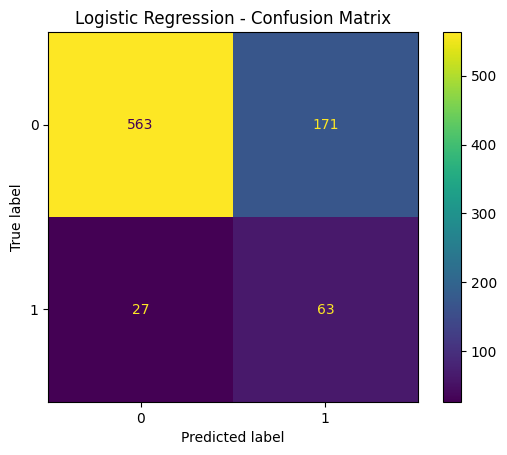


**************************************************
EVALUATION FOR RANDOM FOREST
**************************************************
  Accuracy: 0.8701
  Precision: 0.3896
  Recall: 0.3333
  F1 Score: 0.3593
  ROC AUC: 0.7318
  Confusion Matrix:
 [[687  47]
 [ 60  30]]


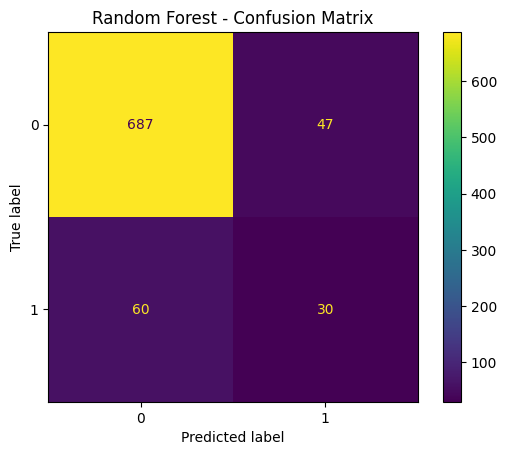


**************************************************
EVALUATION FOR GRADIENT BOOSTING
**************************************************
  Accuracy: 0.8835
  Precision: 0.4559
  Recall: 0.3444
  F1 Score: 0.3924
  ROC AUC: 0.7393
  Confusion Matrix:
 [[697  37]
 [ 59  31]]


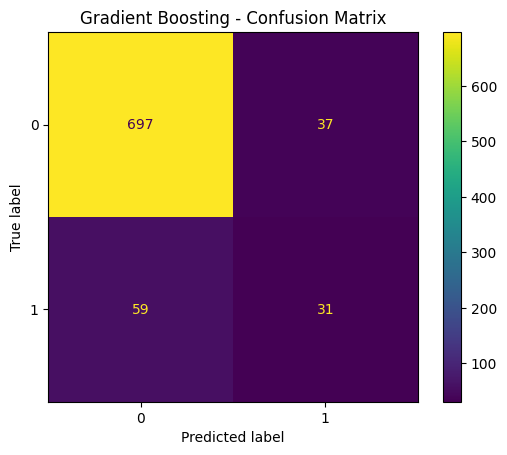


**************************************************
EVALUATION FOR K-NEAREST NEIGHBORS
**************************************************
  Accuracy: 0.8811
  Precision: 0.4524
  Recall: 0.4222
  F1 Score: 0.4368
  ROC AUC: 0.7167
  Confusion Matrix:
 [[688  46]
 [ 52  38]]


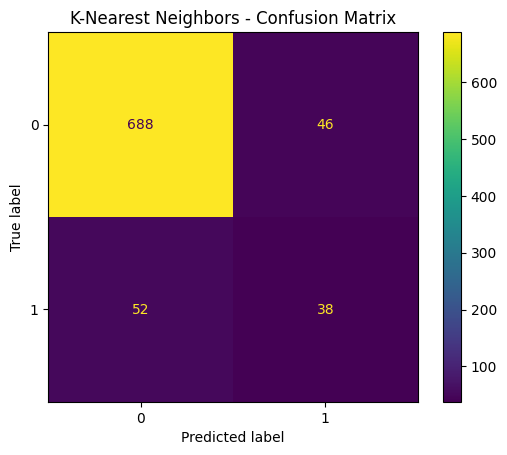

In [ ]:
# Evaluate all best models
for name, model in best_models.items():
    evaluate_model(model, x_test, y_test, model_name=name)

#### Business And Statistical Insights

**Evaluation Metrics Used**

Each model was evaluated on the test set using:
- **Accuracy:** Overall correctness of predictions
- **Precision:** Of all predicted positives, how many were actually positive
- **Recall:** Of all actual positives, how many were correctly predicted
- **F1 Score:** Harmonic mean of precision and recall — balances false positives and false negatives
- **ROC AUC:** Measures the model’s ability to distinguish between classes
- Confusion Matrix: Shows true vs. predicted values for both classes

**Business Insight**

- Logistic Regression has the highest recall (70%), meaning it catches most of the actual subscribers ie, it is useful when missing a potential customer is costly

- K-Nearest Neighbors has the best F1 score (0.4368), indicating the most balanced performance between precision and recall which is ideal for general campaign targeting

- Gradient Boosting offers a middle ground with good precision and recall, and high accuracy.

- Random Forest has the highest accuracy but lower recall ie, it may miss many potential subscribers, which could reduce campaign effectiveness.

***Since our objective is to have balanced targeting with fewer false positives we will go with the K-Nearest Neighbour Model.***
  
  Having the following Metrices
  - Accuracy  0.8811
  - Precision: 0.4524
  - Recall: 0.4222
  - F1 Score: 0.4368
  - ROC AUC: 0.7167

## Explainability

In [ ]:
import shap
# Select the best model
best_model_name = max(model_results, key=lambda k: model_results[k]['Test_f1_score'])
best_model = best_models[best_model_name]
print(f"\nBest model selected for explainability: {best_model_name}")


Best model selected for explainability: K-Nearest Neighbors


In [ ]:
# Create feature names matching x_test shape
feature_names = [f"feature_{i}" for i in range(x_test.shape[1])]
print(f"Using {len(feature_names)} feature names.")

Using 20 feature names.


In [ ]:
# Convert x_test to DataFrame
sample_X_shap = pd.DataFrame(x_test, columns=feature_names)

In [ ]:
# Define predict_proba function
def predict_proba_best_model(arr):
    return best_model.predict_proba(arr)[:, 1]

In [ ]:
# Create SHAP KernelExplainer
background_data = sample_X_shap.sample(n=min(100, len(sample_X_shap)), random_state=42)
explainer = shap.KernelExplainer(predict_proba_best_model, background_data)

In [ ]:
# Compute SHAP values for 500 samples
n_samples = min(500, len(sample_X_shap))
print(f"\nCalculating SHAP values for {n_samples} samples...")
sample_X_for_shap = sample_X_shap.sample(n=n_samples, random_state=42)
shap_values = explainer.shap_values(sample_X_for_shap)
print("SHAP value calculation complete.")


Calculating SHAP values for 500 samples...


  0%|          | 0/500 [00:00<?, ?it/s]

SHAP value calculation complete.


Analyzes and visualizes SHAP values for model explainability.

* Args:
  * shap_values (np.ndarray): SHAP values from the explainer.
  * sample_X (pd.DataFrame): The subset of data used for the explainer.
  * feature_names (np.ndarray or list): Names of the features.
  * top_n (int): Number of top features to display in the summary plot.


In [ ]:
# Analyze and visualize SHAP values
def analyze_shap_values(shap_values, sample_x, feature_names, explainer, top_n=10):
    print("\n" + "*"*50)
    print("ANALYZING SHAP VALUES")
    print("*"*50)

    if not isinstance(sample_x, pd.DataFrame):
        sample_x = pd.DataFrame(sample_x, columns=feature_names)

    # SHAP summary plot
    print(f"Generating SHAP summary plot (top {top_n} features)...")
    shap.summary_plot(shap_values, sample_x, show=False, max_display=top_n)
    plt.title('SHAP Summary Plot')
    plt.show()

    # Feature importance
    if isinstance(shap_values, list):
        mean_abs = np.abs(shap_values[1]).mean(axis=0)
    else:
        mean_abs = np.abs(shap_values).mean(axis=0)

    importance = pd.DataFrame({
        'Feature': feature_names,
        'Mean_Abs_SHAP': mean_abs
    }).sort_values(by='Mean_Abs_SHAP', ascending=False)
    print("\nTop features by mean absolute SHAP value:")
    print(importance.head(top_n))

    # SHAP force plots for the first 5 samples
    print("\nGenerating SHAP force plots for first 5 samples...")
    for i in range(min(5, len(sample_x))):
        shap.force_plot(
            explainer.expected_value,
            shap_values[i],
            sample_x.iloc[i],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot for Sample {i}')
        plt.show()


**************************************************
ANALYZING SHAP VALUES
**************************************************
Generating SHAP summary plot (top 10 features)...


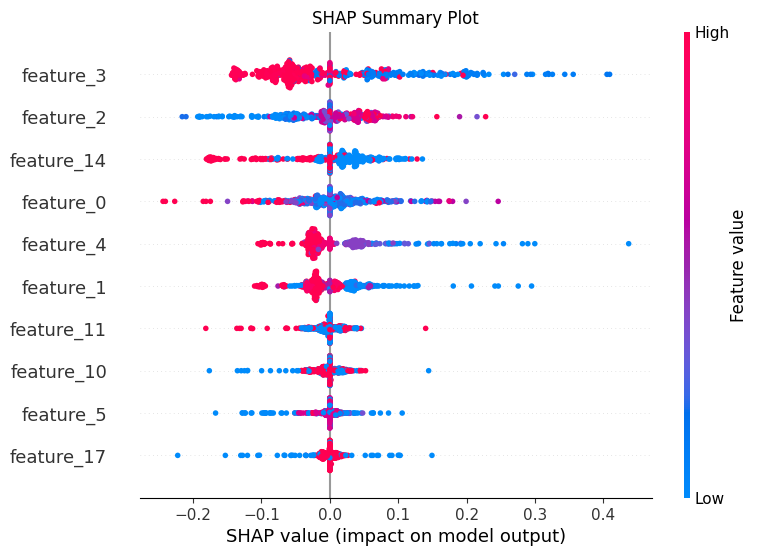


Top features by mean absolute SHAP value:
       Feature  Mean_Abs_SHAP
3    feature_3       0.082236
2    feature_2       0.046079
14  feature_14       0.045047
0    feature_0       0.040980
4    feature_4       0.038847
1    feature_1       0.032518
11  feature_11       0.013897
10  feature_10       0.013835
5    feature_5       0.011734
17  feature_17       0.010566

Generating SHAP force plots for first 5 samples...


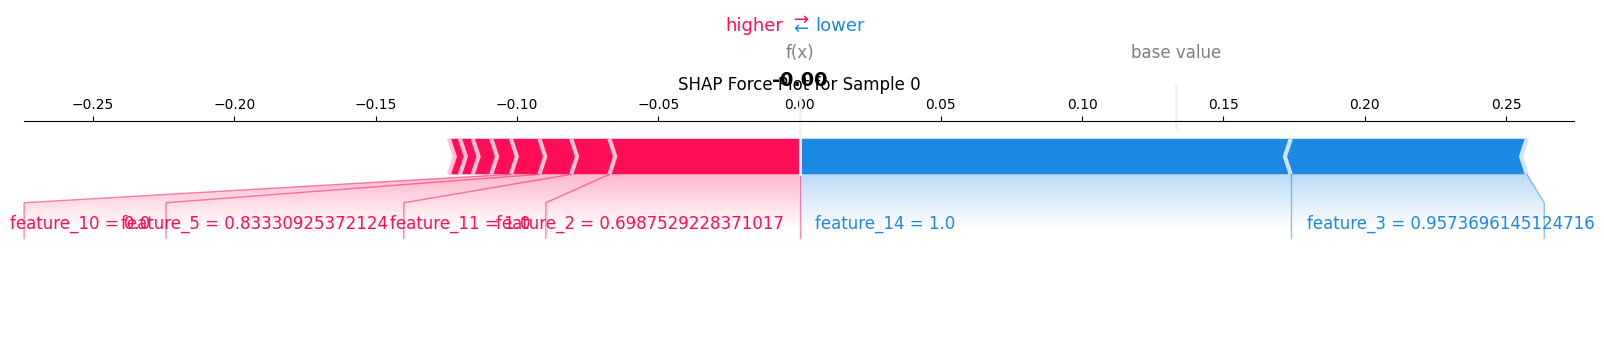

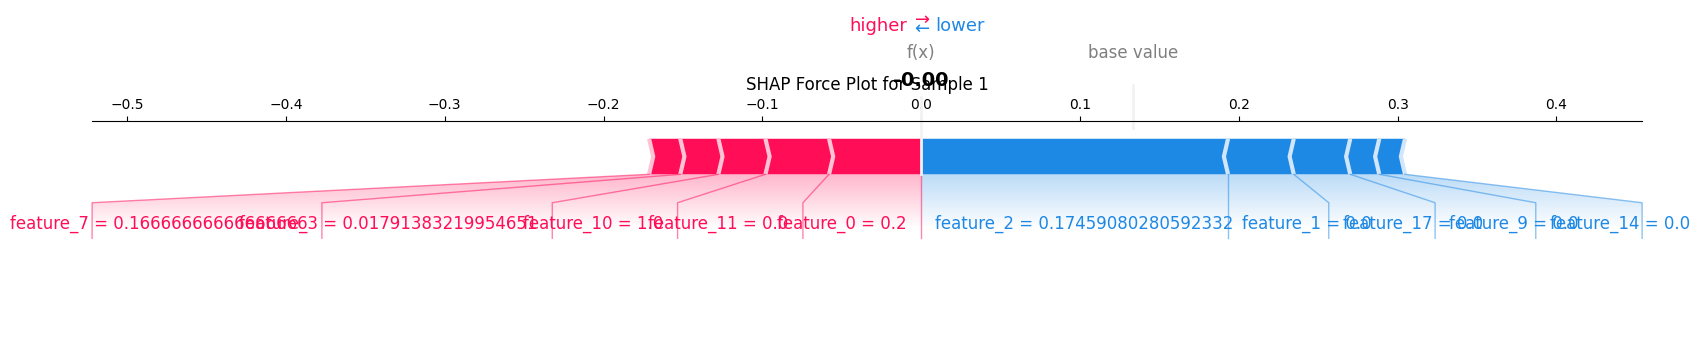

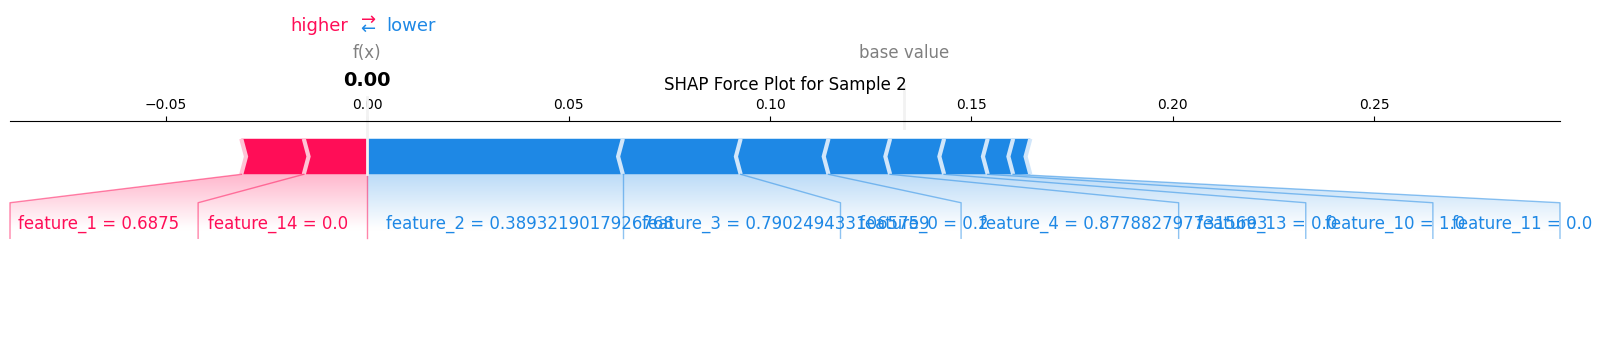

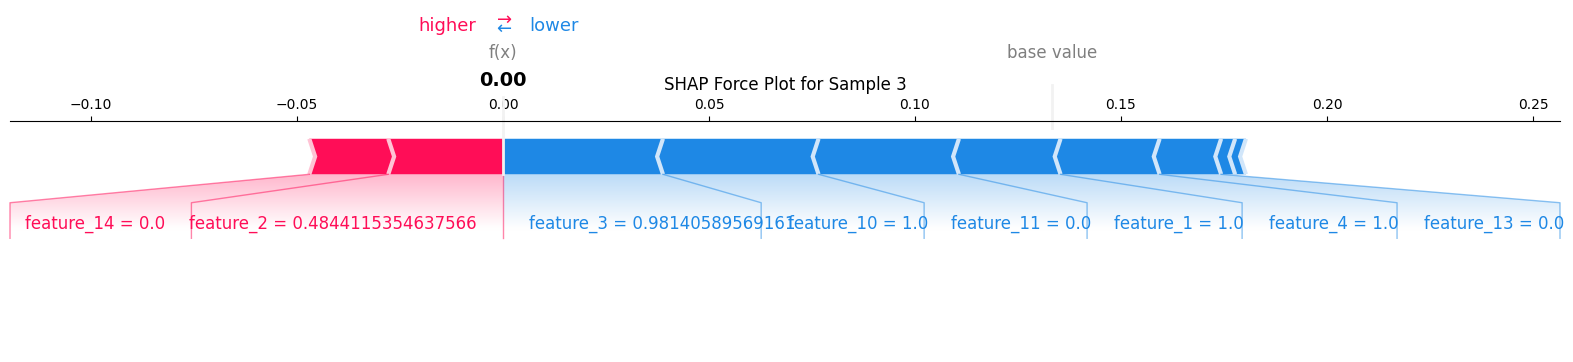

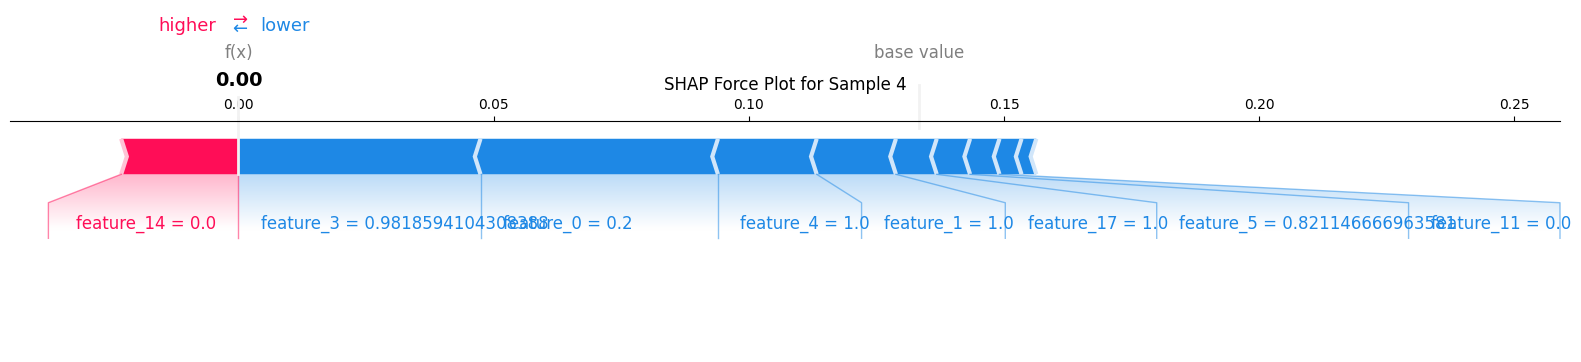

In [ ]:
# Run SHAP analysis
analyze_shap_values(shap_values, sample_X_for_shap, feature_names, explainer)

**SHAP Explainability Insights for K-Nearest Neighbors**

**Top 10 Most Influential Features (by SHAP value)**

| Rank | Feature       | SHAP Impact | Interpretation |
|------|---------------|-------------|----------------|
| 1    | feature_3     | 0.0822      | Highest influence on predictions |
| 2    | feature_2     | 0.0461      | Strong secondary driver |
| 3    | feature_14    | 0.0450      | Close third in importance |
| 4    | feature_0     | 0.0410      | Meaningful contributor |
| 5    | feature_4     | 0.0388      | Moderate influence |
| 6    | feature_1     | 0.0325      | Moderate influence |
| 7–10 | features 11, 10, 5, 17 | ~0.01–0.014 | Lower but still relevant |

**SHAP Summary Plot**
- **Horizontal spread**: The wider the spread of SHAP values for a feature, the more impact it has on predictions
- **Color gradient**:
  - Red dots = high feature values
  - Blue dots = low feature values
  - If red dots are mostly on the right (positive SHAP values), high values of that feature increase the likelihood of subscription
  - If red dots are on the left, high values reduce the likelihood

**Business Insight**
- SHAP shows which features drive predictions
- This helps marketers:
  - Focus on the traits that matter most
  - Personalize outreach strategies based on what influences different customer segments

## End-To-End Pipline Complete

Files generated:

* • bank_marketing_prep_pipeline.joblib    (pre-processing + FS)
* • bank_marketing_k-nearest_neighbors.pkl (optimised classifier)
* • SHAP summary plot                      (feature importance)
